In [26]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,Cropping2D
from keras.optimizers import Adam, Adamax, Nadam, Adadelta, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py

from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff


In [33]:
def get_mask(image_id):
    filename = os.path.join(
        Dir, 'land', '{}.tif'.format(image_id))
    msk = tiff.imread(filename)
    msk = msk.astype(np.float32) / 255
    msk_img = np.zeros([size, size], dtype=np.uint8)
    msk_img[:, :] = msk[:, :, 1]
    msk_img ^= 1
    return msk_img


def get_image(image_id):
    filename = os.path.join(
        Dir, 'satellite', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = img.astype(np.float32) / 255
    img_RGB = cv2.resize(img, (Scale_Size, Scale_Size))

    return img_RGB


def reflect_img(img):
    reflect = cv2.copyMakeBorder(img, int(edge_size), int(edge_size), int(edge_size), int(edge_size),
                                 cv2.BORDER_REFLECT)
    return reflect


def rotate_img(img, ang, size):
    rows = size
    cols = size
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 90 * ang, 1)
    dst = cv2.warpAffine(img, M, (cols, rows))
    return dst


def rotate_msk(msk, ang):
    return np.rot90(msk, ang)


def get_patch(img_id, pos=1):
    img_ = []
    msk_ = []
    img = get_image(img_id)
    img = reflect_img(img)
    mask = get_mask(img_id)
    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                x_start = int(Patch_size * i)
                x_end = int(Patch_size * (i + 1) + edge_size * 2)
                y_start = int(Patch_size * j)
                y_end = int(Patch_size * (j + 1) + edge_size * 2)
                x = img[x_start:x_end, y_start:y_end, :]
                # start rotate y and x
                rdm = random.uniform(-2, 5)
                if rdm > 1:
                    ang = rdm // 1
                    x = rotate_img(x, ang,crop_size)
                    y = rotate_msk(y, ang)
                    # print(x.shape)
                    # print(y.shape)

                img_.append(x)
                msk_.append(y[:, :, None])

    return img_, msk_


def get_all_patches(pos=1):
    img_all = []
    msk_all = []
    count = 0
    for img_id in Image_ID:
        img_, msk_ = get_patch(img_id, pos=pos)
        if len(msk_) > 0:
            count = count + 1
            if count == 1:
                img_all = img_
                msk_all = msk_
            else:
                img_all = np.concatenate((img_all, img_), axis=0)
                msk_all = np.concatenate((msk_all, msk_), axis=0)

    # if pos == 1:
    #     np.save(Dir + '/output/data_pos_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)
    #
    # else:
    #     np.save(Dir + '/output/data_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)

    return img_all, msk_all[:, :, :, 0]


def get_normalized_patches():
    img_all, msk_all = get_all_patches()
    #     data = np.load(Dir + '/output/data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    img = img_all
    msk = msk_all
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    print(mean, std)
    print(np.mean(img), np.std(img))
    return img, msk


In [34]:
def get_unet_5():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv10)

    model = Model(inputs=inputs, outputs=cropping_2d)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model





In [35]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())
print(Image_ID)

N_split = 4

Patch_size = 256
crop_size = 288
edge_size = int((crop_size - Patch_size) / 2)
Class_Type = 1
# 1200 = 300 * 4
size = 1024
Scale_Size = Patch_size * N_split
get_size = 100


['Amsterdam_0_0', 'Amsterdam_0_1', 'Amsterdam_0_2', 'Amsterdam_0_3', 'Amsterdam_0_4', 'Amsterdam_0_5', 'Amsterdam_0_6', 'Amsterdam_1_0', 'Amsterdam_1_1', 'Amsterdam_1_2', 'Amsterdam_1_3', 'Amsterdam_1_4', 'Amsterdam_1_5', 'Amsterdam_1_6', 'Amsterdam_2_0', 'Amsterdam_2_1', 'Amsterdam_2_2', 'Amsterdam_2_3', 'Amsterdam_2_4', 'Amsterdam_2_5', 'Amsterdam_2_6', 'Amsterdam_3_0', 'Amsterdam_3_1', 'Amsterdam_3_2', 'Amsterdam_3_3', 'Amsterdam_3_4', 'Amsterdam_3_5', 'Amsterdam_3_6', 'Amsterdam_4_0', 'Amsterdam_4_1', 'Amsterdam_4_2', 'Amsterdam_4_3', 'Amsterdam_4_4', 'Amsterdam_4_5', 'Amsterdam_4_6', 'Amsterdam_5_0', 'Amsterdam_5_1', 'Amsterdam_5_2', 'Amsterdam_5_3', 'Amsterdam_5_4', 'Amsterdam_5_5', 'Amsterdam_5_6', 'Berlin_0_0', 'Berlin_0_1', 'Berlin_0_2', 'Berlin_0_3', 'Berlin_0_4', 'Berlin_0_5', 'Berlin_0_6', 'Berlin_1_0', 'Berlin_1_1', 'Berlin_1_2', 'Berlin_1_3', 'Berlin_1_4', 'Berlin_1_5', 'Berlin_1_6', 'Berlin_2_0', 'Berlin_2_1', 'Berlin_2_2', 'Berlin_2_3', 'Berlin_2_4', 'Berlin_2_5', 'Berl

In [36]:
# In predicting testing dataset, need to use the same mean and std in preprocessing training data
def post_normalize_image(img, mean=0.48894683, std=0.2100344):
    img = (img - mean) / std
    return img


In [37]:
all_Image_ID = sorted(train_img.ImageId.unique())
all_len = len(all_Image_ID)
loop_time = all_len // get_size
last_weight = ''
loop_i = 0
for i in range(loop_time):
    Image_ID = random.sample(all_Image_ID, get_size)
    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]
    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet_5()
    if i != 0:
        print("loaded")
        model.load_weights(last_weight)

    check_point_file_name = str(loop_i) + '_unet5_c1_rotate.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, save_best_only=True)
    model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name
    loop_i += 1
    del x_trn, x_val, y_trn, y_val, model

img_last = all_len - loop_time * get_size
if img_last > 0:
    Image_ID = random.sample(all_Image_ID, img_last)
    print(len(Image_ID))

    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]

    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet_5()
    if loop_i != 0:
        print("loaded")
        model.load_weights(last_weight)
    # model.load_weights("1unet5_c1.hdf5")
    check_point_file_name = str(loop_i) + '_unet5_c1_rotate.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, save_best_only=True)
    model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name


0.48765847 0.21289627


2.1650017e-06 1.0000001


Train on 968 samples, validate on 243 samples
Epoch 1/20


 16/968 [..............................] - ETA: 19:36 - loss: 0.6643 - acc: 0.6429

 32/968 [..............................] - ETA: 10:05 - loss: 0.6270 - acc: 0.7475

 48/968 [>.............................] - ETA: 6:54 - loss: 0.5778 - acc: 0.7699 

 64/968 [>.............................] - ETA: 5:17 - loss: 0.5552 - acc: 0.7805

 80/968 [=>............................] - ETA: 4:19 - loss: 0.5451 - acc: 0.7844

 96/968 [=>............................] - ETA: 3:40 - loss: 0.5279 - acc: 0.7935

112/968 [==>...........................] - ETA: 3:12 - loss: 0.5170 - acc: 0.7973

128/968 [==>...........................] - ETA: 2:51 - loss: 0.5167 - acc: 0.7961

144/968 [===>..........................] - ETA: 2:34 - loss: 0.5052 - acc: 0.8028

160/968 [===>..........................] - ETA: 2:20 - loss: 0.5014 - acc: 0.8044

176/968 [====>.........................] - ETA: 2:09 - loss: 0.5037 - acc: 0.8026

192/968 [====>.........................] - ETA: 2:00 - loss: 0.5028 - acc: 0.8016

208/968 [=====>........................] - ETA: 1:51 - loss: 0.4969 - acc: 0.8042

224/968 [=====>........................] - ETA: 1:44 - loss: 0.4948 - acc: 0.8036

240/968 [======>.......................] - ETA: 1:38 - loss: 0.4960 - acc: 0.8020

256/968 [======>.......................] - ETA: 1:32 - loss: 0.4940 - acc: 0.8019

272/968 [=======>......................] - ETA: 1:27 - loss: 0.4876 - acc: 0.8048

288/968 [=======>......................] - ETA: 1:22 - loss: 0.4834 - acc: 0.8065

304/968 [========>.....................] - ETA: 1:18 - loss: 0.4843 - acc: 0.8062

320/968 [========>.....................] - ETA: 1:14 - loss: 0.4842 - acc: 0.8057

336/968 [=========>....................] - ETA: 1:11 - loss: 0.4849 - acc: 0.8053

352/968 [=========>....................] - ETA: 1:07 - loss: 0.4817 - acc: 0.8073

368/968 [==========>...................] - ETA: 1:04 - loss: 0.4779 - acc: 0.8106

384/968 [==========>...................] - ETA: 1:01 - loss: 0.4766 - acc: 0.8101

400/968 [===========>..................] - ETA: 58s - loss: 0.4768 - acc: 0.8096 

416/968 [===========>..................] - ETA: 56s - loss: 0.4745 - acc: 0.8114

432/968 [============>.................] - ETA: 53s - loss: 0.4725 - acc: 0.8115

448/968 [============>.................] - ETA: 51s - loss: 0.4729 - acc: 0.8108

464/968 [=============>................] - ETA: 48s - loss: 0.4728 - acc: 0.8098

480/968 [=============>................] - ETA: 46s - loss: 0.4724 - acc: 0.8092

496/968 [==============>...............] - ETA: 44s - loss: 0.4712 - acc: 0.8101

512/968 [==============>...............] - ETA: 42s - loss: 0.4703 - acc: 0.8108

528/968 [===============>..............] - ETA: 40s - loss: 0.4708 - acc: 0.8098

544/968 [===============>..............] - ETA: 38s - loss: 0.4682 - acc: 0.8104

560/968 [================>.............] - ETA: 36s - loss: 0.4674 - acc: 0.8101

576/968 [================>.............] - ETA: 34s - loss: 0.4670 - acc: 0.8099

592/968 [=================>............] - ETA: 33s - loss: 0.4633 - acc: 0.8119

608/968 [=================>............] - ETA: 31s - loss: 0.4614 - acc: 0.8125

624/968 [==================>...........] - ETA: 29s - loss: 0.4611 - acc: 0.8123

640/968 [==================>...........] - ETA: 28s - loss: 0.4599 - acc: 0.8124

656/968 [===================>..........] - ETA: 26s - loss: 0.4581 - acc: 0.8127

672/968 [===================>..........] - ETA: 24s - loss: 0.4575 - acc: 0.8126

688/968 [====================>.........] - ETA: 23s - loss: 0.4568 - acc: 0.8126

704/968 [====================>.........] - ETA: 21s - loss: 0.4565 - acc: 0.8125

720/968 [=====================>........] - ETA: 20s - loss: 0.4560 - acc: 0.8128

736/968 [=====================>........] - ETA: 18s - loss: 0.4538 - acc: 0.8136

752/968 [======================>.......] - ETA: 17s - loss: 0.4513 - acc: 0.8147

768/968 [======================>.......] - ETA: 16s - loss: 0.4510 - acc: 0.8145

784/968 [=======================>......] - ETA: 14s - loss: 0.4496 - acc: 0.8148

800/968 [=======================>......] - ETA: 13s - loss: 0.4483 - acc: 0.8152

816/968 [========================>.....] - ETA: 12s - loss: 0.4482 - acc: 0.8151

832/968 [========================>.....] - ETA: 10s - loss: 0.4477 - acc: 0.8152

848/968 [=========================>....] - ETA: 9s - loss: 0.4464 - acc: 0.8157 

864/968 [=========================>....] - ETA: 8s - loss: 0.4452 - acc: 0.8164

880/968 [==========================>...] - ETA: 6s - loss: 0.4433 - acc: 0.8171

896/968 [==========================>...] - ETA: 5s - loss: 0.4416 - acc: 0.8178

912/968 [===========================>..] - ETA: 4s - loss: 0.4414 - acc: 0.8178

928/968 [===========================>..] - ETA: 3s - loss: 0.4401 - acc: 0.8183

944/968 [============================>.] - ETA: 1s - loss: 0.4394 - acc: 0.8180

960/968 [============================>.] - ETA: 0s - loss: 0.4372 - acc: 0.8190

968/968 [==============================] - 80s 83ms/step - loss: 0.4368 - acc: 0.8190 - val_loss: 0.4030 - val_acc: 0.8153


Epoch 2/20


 16/968 [..............................] - ETA: 53s - loss: 0.4377 - acc: 0.7993

 32/968 [..............................] - ETA: 52s - loss: 0.3890 - acc: 0.8380

 48/968 [>.............................] - ETA: 51s - loss: 0.3919 - acc: 0.8350

 64/968 [>.............................] - ETA: 50s - loss: 0.3807 - acc: 0.8374

 80/968 [=>............................] - ETA: 49s - loss: 0.3819 - acc: 0.8365

 96/968 [=>............................] - ETA: 49s - loss: 0.3814 - acc: 0.8369

112/968 [==>...........................] - ETA: 48s - loss: 0.3690 - acc: 0.8416

128/968 [==>...........................] - ETA: 47s - loss: 0.3737 - acc: 0.8382

144/968 [===>..........................] - ETA: 46s - loss: 0.3772 - acc: 0.8365

160/968 [===>..........................] - ETA: 45s - loss: 0.3758 - acc: 0.8373

176/968 [====>.........................] - ETA: 44s - loss: 0.3815 - acc: 0.8330

192/968 [====>.........................] - ETA: 43s - loss: 0.3771 - acc: 0.8344

208/968 [=====>........................] - ETA: 42s - loss: 0.3724 - acc: 0.8365

224/968 [=====>........................] - ETA: 41s - loss: 0.3690 - acc: 0.8373

240/968 [======>.......................] - ETA: 40s - loss: 0.3689 - acc: 0.8382

256/968 [======>.......................] - ETA: 40s - loss: 0.3703 - acc: 0.8361

272/968 [=======>......................] - ETA: 39s - loss: 0.3728 - acc: 0.8360

288/968 [=======>......................] - ETA: 38s - loss: 0.3717 - acc: 0.8360

304/968 [========>.....................] - ETA: 37s - loss: 0.3756 - acc: 0.8340

320/968 [========>.....................] - ETA: 36s - loss: 0.3781 - acc: 0.8332

336/968 [=========>....................] - ETA: 35s - loss: 0.3787 - acc: 0.8328

352/968 [=========>....................] - ETA: 34s - loss: 0.3823 - acc: 0.8313

368/968 [==========>...................] - ETA: 33s - loss: 0.3852 - acc: 0.8308

384/968 [==========>...................] - ETA: 32s - loss: 0.3841 - acc: 0.8318

400/968 [===========>..................] - ETA: 31s - loss: 0.3840 - acc: 0.8319

416/968 [===========>..................] - ETA: 31s - loss: 0.3851 - acc: 0.8315

432/968 [============>.................] - ETA: 30s - loss: 0.3853 - acc: 0.8317

448/968 [============>.................] - ETA: 29s - loss: 0.3840 - acc: 0.8331

464/968 [=============>................] - ETA: 28s - loss: 0.3851 - acc: 0.8328

480/968 [=============>................] - ETA: 27s - loss: 0.3843 - acc: 0.8334

496/968 [==============>...............] - ETA: 26s - loss: 0.3845 - acc: 0.8338

512/968 [==============>...............] - ETA: 25s - loss: 0.3837 - acc: 0.8341

528/968 [===============>..............] - ETA: 24s - loss: 0.3829 - acc: 0.8348

544/968 [===============>..............] - ETA: 23s - loss: 0.3814 - acc: 0.8356

560/968 [================>.............] - ETA: 22s - loss: 0.3809 - acc: 0.8360

576/968 [================>.............] - ETA: 22s - loss: 0.3801 - acc: 0.8362

592/968 [=================>............] - ETA: 21s - loss: 0.3781 - acc: 0.8374

608/968 [=================>............] - ETA: 20s - loss: 0.3793 - acc: 0.8372

624/968 [==================>...........] - ETA: 19s - loss: 0.3779 - acc: 0.8378

640/968 [==================>...........] - ETA: 18s - loss: 0.3786 - acc: 0.8375

656/968 [===================>..........] - ETA: 17s - loss: 0.3800 - acc: 0.8367

672/968 [===================>..........] - ETA: 16s - loss: 0.3778 - acc: 0.8381

688/968 [====================>.........] - ETA: 15s - loss: 0.3757 - acc: 0.8388

704/968 [====================>.........] - ETA: 14s - loss: 0.3756 - acc: 0.8390

720/968 [=====================>........] - ETA: 13s - loss: 0.3763 - acc: 0.8385

736/968 [=====================>........] - ETA: 13s - loss: 0.3769 - acc: 0.8370

752/968 [======================>.......] - ETA: 12s - loss: 0.3759 - acc: 0.8373

768/968 [======================>.......] - ETA: 11s - loss: 0.3746 - acc: 0.8375

784/968 [=======================>......] - ETA: 10s - loss: 0.3762 - acc: 0.8367

800/968 [=======================>......] - ETA: 9s - loss: 0.3758 - acc: 0.8365 

816/968 [========================>.....] - ETA: 8s - loss: 0.3765 - acc: 0.8363

832/968 [========================>.....] - ETA: 7s - loss: 0.3763 - acc: 0.8366

848/968 [=========================>....] - ETA: 6s - loss: 0.3763 - acc: 0.8366

864/968 [=========================>....] - ETA: 5s - loss: 0.3771 - acc: 0.8361

880/968 [==========================>...] - ETA: 4s - loss: 0.3762 - acc: 0.8363

896/968 [==========================>...] - ETA: 4s - loss: 0.3765 - acc: 0.8364

912/968 [===========================>..] - ETA: 3s - loss: 0.3771 - acc: 0.8362

928/968 [===========================>..] - ETA: 2s - loss: 0.3768 - acc: 0.8363

944/968 [============================>.] - ETA: 1s - loss: 0.3770 - acc: 0.8360

960/968 [============================>.] - ETA: 0s - loss: 0.3778 - acc: 0.8357

968/968 [==============================] - 59s 61ms/step - loss: 0.3772 - acc: 0.8362 - val_loss: 0.3689 - val_acc: 0.8365


Epoch 3/20


 16/968 [..............................] - ETA: 53s - loss: 0.3270 - acc: 0.8600

 32/968 [..............................] - ETA: 52s - loss: 0.3564 - acc: 0.8450

 48/968 [>.............................] - ETA: 51s - loss: 0.3668 - acc: 0.8412

 64/968 [>.............................] - ETA: 50s - loss: 0.3717 - acc: 0.8389

 80/968 [=>............................] - ETA: 50s - loss: 0.3610 - acc: 0.8462

 96/968 [=>............................] - ETA: 49s - loss: 0.3585 - acc: 0.8489

112/968 [==>...........................] - ETA: 48s - loss: 0.3652 - acc: 0.8443

128/968 [==>...........................] - ETA: 47s - loss: 0.3608 - acc: 0.8444

144/968 [===>..........................] - ETA: 46s - loss: 0.3804 - acc: 0.8387

160/968 [===>..........................] - ETA: 45s - loss: 0.3792 - acc: 0.8380

176/968 [====>.........................] - ETA: 44s - loss: 0.3778 - acc: 0.8396

192/968 [====>.........................] - ETA: 43s - loss: 0.3756 - acc: 0.8416

208/968 [=====>........................] - ETA: 42s - loss: 0.3729 - acc: 0.8436

224/968 [=====>........................] - ETA: 42s - loss: 0.3708 - acc: 0.8447

240/968 [======>.......................] - ETA: 41s - loss: 0.3744 - acc: 0.8427

256/968 [======>.......................] - ETA: 40s - loss: 0.3753 - acc: 0.8416

272/968 [=======>......................] - ETA: 39s - loss: 0.3745 - acc: 0.8414

288/968 [=======>......................] - ETA: 38s - loss: 0.3718 - acc: 0.8426

304/968 [========>.....................] - ETA: 37s - loss: 0.3689 - acc: 0.8435

320/968 [========>.....................] - ETA: 36s - loss: 0.3691 - acc: 0.8430

336/968 [=========>....................] - ETA: 35s - loss: 0.3688 - acc: 0.8430

352/968 [=========>....................] - ETA: 34s - loss: 0.3661 - acc: 0.8444

368/968 [==========>...................] - ETA: 33s - loss: 0.3652 - acc: 0.8445

384/968 [==========>...................] - ETA: 32s - loss: 0.3630 - acc: 0.8454

400/968 [===========>..................] - ETA: 32s - loss: 0.3609 - acc: 0.8469

416/968 [===========>..................] - ETA: 31s - loss: 0.3599 - acc: 0.8473

432/968 [============>.................] - ETA: 30s - loss: 0.3582 - acc: 0.8481

448/968 [============>.................] - ETA: 29s - loss: 0.3572 - acc: 0.8486

464/968 [=============>................] - ETA: 28s - loss: 0.3575 - acc: 0.8478

480/968 [=============>................] - ETA: 27s - loss: 0.3566 - acc: 0.8484

496/968 [==============>...............] - ETA: 26s - loss: 0.3580 - acc: 0.8475

512/968 [==============>...............] - ETA: 25s - loss: 0.3587 - acc: 0.8468

528/968 [===============>..............] - ETA: 24s - loss: 0.3592 - acc: 0.8466

544/968 [===============>..............] - ETA: 23s - loss: 0.3589 - acc: 0.8465

560/968 [================>.............] - ETA: 23s - loss: 0.3586 - acc: 0.8466

576/968 [================>.............] - ETA: 22s - loss: 0.3564 - acc: 0.8475

592/968 [=================>............] - ETA: 21s - loss: 0.3549 - acc: 0.8483

608/968 [=================>............] - ETA: 20s - loss: 0.3576 - acc: 0.8480

624/968 [==================>...........] - ETA: 19s - loss: 0.3573 - acc: 0.8479

640/968 [==================>...........] - ETA: 18s - loss: 0.3562 - acc: 0.8482

656/968 [===================>..........] - ETA: 17s - loss: 0.3541 - acc: 0.8493

672/968 [===================>..........] - ETA: 16s - loss: 0.3526 - acc: 0.8500

688/968 [====================>.........] - ETA: 15s - loss: 0.3500 - acc: 0.8512

704/968 [====================>.........] - ETA: 14s - loss: 0.3489 - acc: 0.8518

720/968 [=====================>........] - ETA: 13s - loss: 0.3475 - acc: 0.8525

736/968 [=====================>........] - ETA: 13s - loss: 0.3484 - acc: 0.8519

752/968 [======================>.......] - ETA: 12s - loss: 0.3481 - acc: 0.8521

768/968 [======================>.......] - ETA: 11s - loss: 0.3502 - acc: 0.8507

784/968 [=======================>......] - ETA: 10s - loss: 0.3498 - acc: 0.8508

800/968 [=======================>......] - ETA: 9s - loss: 0.3497 - acc: 0.8508 

816/968 [========================>.....] - ETA: 8s - loss: 0.3504 - acc: 0.8504

832/968 [========================>.....] - ETA: 7s - loss: 0.3508 - acc: 0.8504

848/968 [=========================>....] - ETA: 6s - loss: 0.3497 - acc: 0.8508

864/968 [=========================>....] - ETA: 5s - loss: 0.3497 - acc: 0.8515

880/968 [==========================>...] - ETA: 4s - loss: 0.3509 - acc: 0.8511

896/968 [==========================>...] - ETA: 4s - loss: 0.3505 - acc: 0.8514

912/968 [===========================>..] - ETA: 3s - loss: 0.3505 - acc: 0.8514

928/968 [===========================>..] - ETA: 2s - loss: 0.3511 - acc: 0.8510

944/968 [============================>.] - ETA: 1s - loss: 0.3517 - acc: 0.8509

960/968 [============================>.] - ETA: 0s - loss: 0.3501 - acc: 0.8518

968/968 [==============================] - 59s 61ms/step - loss: 0.3502 - acc: 0.8517 - val_loss: 0.3361 - val_acc: 0.8571


Epoch 4/20


 16/968 [..............................] - ETA: 54s - loss: 0.3464 - acc: 0.8585

 32/968 [..............................] - ETA: 52s - loss: 0.3422 - acc: 0.8619

 48/968 [>.............................] - ETA: 51s - loss: 0.3484 - acc: 0.8505

 64/968 [>.............................] - ETA: 51s - loss: 0.3456 - acc: 0.8495

 80/968 [=>............................] - ETA: 50s - loss: 0.3402 - acc: 0.8528

 96/968 [=>............................] - ETA: 49s - loss: 0.3424 - acc: 0.8526

112/968 [==>...........................] - ETA: 48s - loss: 0.3341 - acc: 0.8565

128/968 [==>...........................] - ETA: 47s - loss: 0.3347 - acc: 0.8558

144/968 [===>..........................] - ETA: 46s - loss: 0.3336 - acc: 0.8561

160/968 [===>..........................] - ETA: 45s - loss: 0.3358 - acc: 0.8547

176/968 [====>.........................] - ETA: 44s - loss: 0.3394 - acc: 0.8528

192/968 [====>.........................] - ETA: 43s - loss: 0.3377 - acc: 0.8537

208/968 [=====>........................] - ETA: 42s - loss: 0.3315 - acc: 0.8555

224/968 [=====>........................] - ETA: 41s - loss: 0.3373 - acc: 0.8521

240/968 [======>.......................] - ETA: 41s - loss: 0.3408 - acc: 0.8501

256/968 [======>.......................] - ETA: 40s - loss: 0.3389 - acc: 0.8508

272/968 [=======>......................] - ETA: 39s - loss: 0.3365 - acc: 0.8522

288/968 [=======>......................] - ETA: 38s - loss: 0.3353 - acc: 0.8533

304/968 [========>.....................] - ETA: 37s - loss: 0.3327 - acc: 0.8554

320/968 [========>.....................] - ETA: 36s - loss: 0.3318 - acc: 0.8562

336/968 [=========>....................] - ETA: 35s - loss: 0.3300 - acc: 0.8573

352/968 [=========>....................] - ETA: 34s - loss: 0.3273 - acc: 0.8586

368/968 [==========>...................] - ETA: 33s - loss: 0.3265 - acc: 0.8595

384/968 [==========>...................] - ETA: 32s - loss: 0.3256 - acc: 0.8603

400/968 [===========>..................] - ETA: 32s - loss: 0.3245 - acc: 0.8610

416/968 [===========>..................] - ETA: 31s - loss: 0.3243 - acc: 0.8609

432/968 [============>.................] - ETA: 30s - loss: 0.3251 - acc: 0.8603

448/968 [============>.................] - ETA: 29s - loss: 0.3263 - acc: 0.8601

464/968 [=============>................] - ETA: 28s - loss: 0.3263 - acc: 0.8605

480/968 [=============>................] - ETA: 27s - loss: 0.3262 - acc: 0.8605

496/968 [==============>...............] - ETA: 26s - loss: 0.3277 - acc: 0.8603

512/968 [==============>...............] - ETA: 25s - loss: 0.3287 - acc: 0.8597

528/968 [===============>..............] - ETA: 24s - loss: 0.3296 - acc: 0.8592

544/968 [===============>..............] - ETA: 23s - loss: 0.3291 - acc: 0.8596

560/968 [================>.............] - ETA: 23s - loss: 0.3294 - acc: 0.8595

576/968 [================>.............] - ETA: 22s - loss: 0.3293 - acc: 0.8596

592/968 [=================>............] - ETA: 21s - loss: 0.3299 - acc: 0.8592

608/968 [=================>............] - ETA: 20s - loss: 0.3294 - acc: 0.8597

624/968 [==================>...........] - ETA: 19s - loss: 0.3281 - acc: 0.8602

640/968 [==================>...........] - ETA: 18s - loss: 0.3284 - acc: 0.8602

656/968 [===================>..........] - ETA: 17s - loss: 0.3281 - acc: 0.8603

672/968 [===================>..........] - ETA: 16s - loss: 0.3278 - acc: 0.8604

688/968 [====================>.........] - ETA: 15s - loss: 0.3269 - acc: 0.8608

704/968 [====================>.........] - ETA: 14s - loss: 0.3275 - acc: 0.8603

720/968 [=====================>........] - ETA: 13s - loss: 0.3259 - acc: 0.8610

736/968 [=====================>........] - ETA: 13s - loss: 0.3248 - acc: 0.8617

752/968 [======================>.......] - ETA: 12s - loss: 0.3244 - acc: 0.8620

768/968 [======================>.......] - ETA: 11s - loss: 0.3249 - acc: 0.8622

784/968 [=======================>......] - ETA: 10s - loss: 0.3242 - acc: 0.8624

800/968 [=======================>......] - ETA: 9s - loss: 0.3243 - acc: 0.8624 

816/968 [========================>.....] - ETA: 8s - loss: 0.3226 - acc: 0.8634

832/968 [========================>.....] - ETA: 7s - loss: 0.3224 - acc: 0.8635

848/968 [=========================>....] - ETA: 6s - loss: 0.3219 - acc: 0.8638

864/968 [=========================>....] - ETA: 5s - loss: 0.3232 - acc: 0.8633

880/968 [==========================>...] - ETA: 4s - loss: 0.3224 - acc: 0.8636

896/968 [==========================>...] - ETA: 4s - loss: 0.3228 - acc: 0.8633

912/968 [===========================>..] - ETA: 3s - loss: 0.3229 - acc: 0.8629

928/968 [===========================>..] - ETA: 2s - loss: 0.3230 - acc: 0.8628

944/968 [============================>.] - ETA: 1s - loss: 0.3238 - acc: 0.8623

960/968 [============================>.] - ETA: 0s - loss: 0.3233 - acc: 0.8626

968/968 [==============================] - 59s 61ms/step - loss: 0.3233 - acc: 0.8625 - val_loss: 0.3348 - val_acc: 0.8578


Epoch 5/20


 16/968 [..............................] - ETA: 54s - loss: 0.3042 - acc: 0.8733

 32/968 [..............................] - ETA: 53s - loss: 0.3505 - acc: 0.8483

 48/968 [>.............................] - ETA: 52s - loss: 0.3460 - acc: 0.8506

 64/968 [>.............................] - ETA: 51s - loss: 0.3279 - acc: 0.8572

 80/968 [=>............................] - ETA: 50s - loss: 0.3271 - acc: 0.8576

 96/968 [=>............................] - ETA: 49s - loss: 0.3261 - acc: 0.8577

112/968 [==>...........................] - ETA: 48s - loss: 0.3345 - acc: 0.8604

128/968 [==>...........................] - ETA: 47s - loss: 0.3353 - acc: 0.8597

144/968 [===>..........................] - ETA: 46s - loss: 0.3367 - acc: 0.8586

160/968 [===>..........................] - ETA: 45s - loss: 0.3341 - acc: 0.8619

176/968 [====>.........................] - ETA: 44s - loss: 0.3326 - acc: 0.8646

192/968 [====>.........................] - ETA: 43s - loss: 0.3329 - acc: 0.8645

208/968 [=====>........................] - ETA: 42s - loss: 0.3292 - acc: 0.8668

224/968 [=====>........................] - ETA: 42s - loss: 0.3320 - acc: 0.8658

240/968 [======>.......................] - ETA: 41s - loss: 0.3320 - acc: 0.8657

256/968 [======>.......................] - ETA: 40s - loss: 0.3282 - acc: 0.8673

272/968 [=======>......................] - ETA: 39s - loss: 0.3287 - acc: 0.8670

288/968 [=======>......................] - ETA: 38s - loss: 0.3300 - acc: 0.8653

304/968 [========>.....................] - ETA: 37s - loss: 0.3273 - acc: 0.8665

320/968 [========>.....................] - ETA: 36s - loss: 0.3260 - acc: 0.8672

336/968 [=========>....................] - ETA: 35s - loss: 0.3263 - acc: 0.8667

352/968 [=========>....................] - ETA: 34s - loss: 0.3278 - acc: 0.8655

368/968 [==========>...................] - ETA: 33s - loss: 0.3296 - acc: 0.8640

384/968 [==========>...................] - ETA: 32s - loss: 0.3304 - acc: 0.8635

400/968 [===========>..................] - ETA: 32s - loss: 0.3316 - acc: 0.8631

416/968 [===========>..................] - ETA: 31s - loss: 0.3325 - acc: 0.8622

432/968 [============>.................] - ETA: 30s - loss: 0.3317 - acc: 0.8626

448/968 [============>.................] - ETA: 29s - loss: 0.3336 - acc: 0.8617

464/968 [=============>................] - ETA: 28s - loss: 0.3308 - acc: 0.8629

480/968 [=============>................] - ETA: 27s - loss: 0.3289 - acc: 0.8639

496/968 [==============>...............] - ETA: 26s - loss: 0.3283 - acc: 0.8639

512/968 [==============>...............] - ETA: 25s - loss: 0.3291 - acc: 0.8635

528/968 [===============>..............] - ETA: 24s - loss: 0.3299 - acc: 0.8629

544/968 [===============>..............] - ETA: 23s - loss: 0.3304 - acc: 0.8624

560/968 [================>.............] - ETA: 23s - loss: 0.3284 - acc: 0.8631

576/968 [================>.............] - ETA: 22s - loss: 0.3299 - acc: 0.8630

592/968 [=================>............] - ETA: 21s - loss: 0.3297 - acc: 0.8632

608/968 [=================>............] - ETA: 20s - loss: 0.3287 - acc: 0.8636

624/968 [==================>...........] - ETA: 19s - loss: 0.3273 - acc: 0.8642

640/968 [==================>...........] - ETA: 18s - loss: 0.3289 - acc: 0.8632

656/968 [===================>..........] - ETA: 17s - loss: 0.3290 - acc: 0.8630

672/968 [===================>..........] - ETA: 16s - loss: 0.3294 - acc: 0.8625

688/968 [====================>.........] - ETA: 15s - loss: 0.3295 - acc: 0.8621

704/968 [====================>.........] - ETA: 14s - loss: 0.3299 - acc: 0.8619

720/968 [=====================>........] - ETA: 13s - loss: 0.3308 - acc: 0.8613

736/968 [=====================>........] - ETA: 13s - loss: 0.3296 - acc: 0.8619

752/968 [======================>.......] - ETA: 12s - loss: 0.3286 - acc: 0.8623

768/968 [======================>.......] - ETA: 11s - loss: 0.3288 - acc: 0.8617

784/968 [=======================>......] - ETA: 10s - loss: 0.3276 - acc: 0.8622

800/968 [=======================>......] - ETA: 9s - loss: 0.3272 - acc: 0.8623 

816/968 [========================>.....] - ETA: 8s - loss: 0.3278 - acc: 0.8623

832/968 [========================>.....] - ETA: 7s - loss: 0.3267 - acc: 0.8628

848/968 [=========================>....] - ETA: 6s - loss: 0.3250 - acc: 0.8636

864/968 [=========================>....] - ETA: 5s - loss: 0.3244 - acc: 0.8638

880/968 [==========================>...] - ETA: 4s - loss: 0.3236 - acc: 0.8641

896/968 [==========================>...] - ETA: 4s - loss: 0.3236 - acc: 0.8640

912/968 [===========================>..] - ETA: 3s - loss: 0.3234 - acc: 0.8643

928/968 [===========================>..] - ETA: 2s - loss: 0.3223 - acc: 0.8647

944/968 [============================>.] - ETA: 1s - loss: 0.3228 - acc: 0.8646

960/968 [============================>.] - ETA: 0s - loss: 0.3222 - acc: 0.8650

968/968 [==============================] - 59s 61ms/step - loss: 0.3213 - acc: 0.8654 - val_loss: 0.3064 - val_acc: 0.8688


Epoch 6/20


 16/968 [..............................] - ETA: 53s - loss: 0.3369 - acc: 0.8513

 32/968 [..............................] - ETA: 53s - loss: 0.3327 - acc: 0.8616

 48/968 [>.............................] - ETA: 52s - loss: 0.3249 - acc: 0.8654

 64/968 [>.............................] - ETA: 51s - loss: 0.3191 - acc: 0.8670

 80/968 [=>............................] - ETA: 50s - loss: 0.3113 - acc: 0.8689

 96/968 [=>............................] - ETA: 49s - loss: 0.3225 - acc: 0.8649

112/968 [==>...........................] - ETA: 48s - loss: 0.3233 - acc: 0.8649

128/968 [==>...........................] - ETA: 47s - loss: 0.3163 - acc: 0.8678

144/968 [===>..........................] - ETA: 46s - loss: 0.3112 - acc: 0.8697

160/968 [===>..........................] - ETA: 45s - loss: 0.3103 - acc: 0.8699

176/968 [====>.........................] - ETA: 44s - loss: 0.3136 - acc: 0.8683

192/968 [====>.........................] - ETA: 43s - loss: 0.3104 - acc: 0.8698

208/968 [=====>........................] - ETA: 42s - loss: 0.3127 - acc: 0.8680

224/968 [=====>........................] - ETA: 42s - loss: 0.3133 - acc: 0.8691

240/968 [======>.......................] - ETA: 41s - loss: 0.3085 - acc: 0.8715

256/968 [======>.......................] - ETA: 40s - loss: 0.3059 - acc: 0.8726

272/968 [=======>......................] - ETA: 39s - loss: 0.3065 - acc: 0.8724

288/968 [=======>......................] - ETA: 38s - loss: 0.3057 - acc: 0.8731

304/968 [========>.....................] - ETA: 37s - loss: 0.3101 - acc: 0.8700

320/968 [========>.....................] - ETA: 36s - loss: 0.3111 - acc: 0.8695

336/968 [=========>....................] - ETA: 35s - loss: 0.3087 - acc: 0.8706

352/968 [=========>....................] - ETA: 34s - loss: 0.3128 - acc: 0.8685

368/968 [==========>...................] - ETA: 33s - loss: 0.3144 - acc: 0.8677

384/968 [==========>...................] - ETA: 32s - loss: 0.3121 - acc: 0.8689

400/968 [===========>..................] - ETA: 32s - loss: 0.3122 - acc: 0.8686

416/968 [===========>..................] - ETA: 31s - loss: 0.3117 - acc: 0.8687

432/968 [============>.................] - ETA: 30s - loss: 0.3114 - acc: 0.8687

448/968 [============>.................] - ETA: 29s - loss: 0.3106 - acc: 0.8691

464/968 [=============>................] - ETA: 28s - loss: 0.3094 - acc: 0.8703

480/968 [=============>................] - ETA: 27s - loss: 0.3071 - acc: 0.8715

496/968 [==============>...............] - ETA: 26s - loss: 0.3081 - acc: 0.8710

512/968 [==============>...............] - ETA: 25s - loss: 0.3079 - acc: 0.8712

528/968 [===============>..............] - ETA: 24s - loss: 0.3070 - acc: 0.8717

544/968 [===============>..............] - ETA: 23s - loss: 0.3082 - acc: 0.8711

560/968 [================>.............] - ETA: 23s - loss: 0.3070 - acc: 0.8718

576/968 [================>.............] - ETA: 22s - loss: 0.3088 - acc: 0.8708

592/968 [=================>............] - ETA: 21s - loss: 0.3076 - acc: 0.8712

608/968 [=================>............] - ETA: 20s - loss: 0.3077 - acc: 0.8709

624/968 [==================>...........] - ETA: 19s - loss: 0.3066 - acc: 0.8713

640/968 [==================>...........] - ETA: 18s - loss: 0.3043 - acc: 0.8723

656/968 [===================>..........] - ETA: 17s - loss: 0.3035 - acc: 0.8727

672/968 [===================>..........] - ETA: 16s - loss: 0.3027 - acc: 0.8730

688/968 [====================>.........] - ETA: 15s - loss: 0.3026 - acc: 0.8728

704/968 [====================>.........] - ETA: 14s - loss: 0.3017 - acc: 0.8732

720/968 [=====================>........] - ETA: 13s - loss: 0.3004 - acc: 0.8738

736/968 [=====================>........] - ETA: 13s - loss: 0.3005 - acc: 0.8737

752/968 [======================>.......] - ETA: 12s - loss: 0.3001 - acc: 0.8739

768/968 [======================>.......] - ETA: 11s - loss: 0.3000 - acc: 0.8742

784/968 [=======================>......] - ETA: 10s - loss: 0.3003 - acc: 0.8740

800/968 [=======================>......] - ETA: 9s - loss: 0.2996 - acc: 0.8743 

816/968 [========================>.....] - ETA: 8s - loss: 0.2998 - acc: 0.8742

832/968 [========================>.....] - ETA: 7s - loss: 0.3001 - acc: 0.8740

848/968 [=========================>....] - ETA: 6s - loss: 0.3004 - acc: 0.8737

864/968 [=========================>....] - ETA: 5s - loss: 0.2992 - acc: 0.8742

880/968 [==========================>...] - ETA: 4s - loss: 0.2994 - acc: 0.8743

896/968 [==========================>...] - ETA: 4s - loss: 0.2994 - acc: 0.8743

912/968 [===========================>..] - ETA: 3s - loss: 0.2986 - acc: 0.8746

928/968 [===========================>..] - ETA: 2s - loss: 0.2982 - acc: 0.8748

944/968 [============================>.] - ETA: 1s - loss: 0.3001 - acc: 0.8744

960/968 [============================>.] - ETA: 0s - loss: 0.2989 - acc: 0.8750

968/968 [==============================] - 59s 61ms/step - loss: 0.2988 - acc: 0.8751 - val_loss: 0.2954 - val_acc: 0.8737


Epoch 7/20


 16/968 [..............................] - ETA: 54s - loss: 0.2926 - acc: 0.8726

 32/968 [..............................] - ETA: 53s - loss: 0.3115 - acc: 0.8678

 48/968 [>.............................] - ETA: 52s - loss: 0.3148 - acc: 0.8662

 64/968 [>.............................] - ETA: 51s - loss: 0.3032 - acc: 0.8726

 80/968 [=>............................] - ETA: 50s - loss: 0.2959 - acc: 0.8773

 96/968 [=>............................] - ETA: 49s - loss: 0.2978 - acc: 0.8783

112/968 [==>...........................] - ETA: 48s - loss: 0.3017 - acc: 0.8753

128/968 [==>...........................] - ETA: 47s - loss: 0.2924 - acc: 0.8803

144/968 [===>..........................] - ETA: 46s - loss: 0.2942 - acc: 0.8786

160/968 [===>..........................] - ETA: 45s - loss: 0.2972 - acc: 0.8766

176/968 [====>.........................] - ETA: 44s - loss: 0.2974 - acc: 0.8766

192/968 [====>.........................] - ETA: 43s - loss: 0.2985 - acc: 0.8758

208/968 [=====>........................] - ETA: 42s - loss: 0.3000 - acc: 0.8746

224/968 [=====>........................] - ETA: 42s - loss: 0.3048 - acc: 0.8718

240/968 [======>.......................] - ETA: 41s - loss: 0.3051 - acc: 0.8712

256/968 [======>.......................] - ETA: 40s - loss: 0.3020 - acc: 0.8723

272/968 [=======>......................] - ETA: 39s - loss: 0.3070 - acc: 0.8707

288/968 [=======>......................] - ETA: 38s - loss: 0.3031 - acc: 0.8725

304/968 [========>.....................] - ETA: 37s - loss: 0.3016 - acc: 0.8738

320/968 [========>.....................] - ETA: 36s - loss: 0.3052 - acc: 0.8718

336/968 [=========>....................] - ETA: 35s - loss: 0.3084 - acc: 0.8702

352/968 [=========>....................] - ETA: 34s - loss: 0.3064 - acc: 0.8713

368/968 [==========>...................] - ETA: 33s - loss: 0.3069 - acc: 0.8710

384/968 [==========>...................] - ETA: 32s - loss: 0.3072 - acc: 0.8708

400/968 [===========>..................] - ETA: 32s - loss: 0.3070 - acc: 0.8708

416/968 [===========>..................] - ETA: 31s - loss: 0.3058 - acc: 0.8712

432/968 [============>.................] - ETA: 30s - loss: 0.3063 - acc: 0.8713

448/968 [============>.................] - ETA: 29s - loss: 0.3075 - acc: 0.8707

464/968 [=============>................] - ETA: 28s - loss: 0.3091 - acc: 0.8698

480/968 [=============>................] - ETA: 27s - loss: 0.3084 - acc: 0.8700

496/968 [==============>...............] - ETA: 26s - loss: 0.3085 - acc: 0.8696

512/968 [==============>...............] - ETA: 25s - loss: 0.3087 - acc: 0.8696

528/968 [===============>..............] - ETA: 24s - loss: 0.3084 - acc: 0.8696

544/968 [===============>..............] - ETA: 23s - loss: 0.3069 - acc: 0.8703

560/968 [================>.............] - ETA: 23s - loss: 0.3057 - acc: 0.8709

576/968 [================>.............] - ETA: 22s - loss: 0.3053 - acc: 0.8710

592/968 [=================>............] - ETA: 21s - loss: 0.3034 - acc: 0.8721

608/968 [=================>............] - ETA: 20s - loss: 0.3020 - acc: 0.8727

624/968 [==================>...........] - ETA: 19s - loss: 0.3014 - acc: 0.8730

640/968 [==================>...........] - ETA: 18s - loss: 0.3028 - acc: 0.8727

656/968 [===================>..........] - ETA: 17s - loss: 0.2999 - acc: 0.8740

672/968 [===================>..........] - ETA: 16s - loss: 0.2998 - acc: 0.8742

688/968 [====================>.........] - ETA: 15s - loss: 0.2995 - acc: 0.8745

704/968 [====================>.........] - ETA: 14s - loss: 0.2988 - acc: 0.8748

720/968 [=====================>........] - ETA: 13s - loss: 0.2997 - acc: 0.8743

736/968 [=====================>........] - ETA: 13s - loss: 0.2984 - acc: 0.8749

752/968 [======================>.......] - ETA: 12s - loss: 0.2986 - acc: 0.8749

768/968 [======================>.......] - ETA: 11s - loss: 0.2974 - acc: 0.8754

784/968 [=======================>......] - ETA: 10s - loss: 0.2965 - acc: 0.8758

800/968 [=======================>......] - ETA: 9s - loss: 0.2953 - acc: 0.8763 

816/968 [========================>.....] - ETA: 8s - loss: 0.2949 - acc: 0.8765

832/968 [========================>.....] - ETA: 7s - loss: 0.2952 - acc: 0.8765

848/968 [=========================>....] - ETA: 6s - loss: 0.2947 - acc: 0.8769

864/968 [=========================>....] - ETA: 5s - loss: 0.2940 - acc: 0.8773

880/968 [==========================>...] - ETA: 4s - loss: 0.2939 - acc: 0.8774

896/968 [==========================>...] - ETA: 4s - loss: 0.2925 - acc: 0.8780

912/968 [===========================>..] - ETA: 3s - loss: 0.2937 - acc: 0.8776

928/968 [===========================>..] - ETA: 2s - loss: 0.2930 - acc: 0.8778

944/968 [============================>.] - ETA: 1s - loss: 0.2920 - acc: 0.8782

960/968 [============================>.] - ETA: 0s - loss: 0.2921 - acc: 0.8782

968/968 [==============================] - 59s 61ms/step - loss: 0.2927 - acc: 0.8779 - val_loss: 0.2979 - val_acc: 0.8709


Epoch 8/20


 16/968 [..............................] - ETA: 54s - loss: 0.2404 - acc: 0.8997

 32/968 [..............................] - ETA: 53s - loss: 0.2487 - acc: 0.8937

 48/968 [>.............................] - ETA: 52s - loss: 0.2707 - acc: 0.8814

 64/968 [>.............................] - ETA: 51s - loss: 0.2748 - acc: 0.8810

 80/968 [=>............................] - ETA: 50s - loss: 0.2757 - acc: 0.8801

 96/968 [=>............................] - ETA: 49s - loss: 0.2748 - acc: 0.8810

112/968 [==>...........................] - ETA: 48s - loss: 0.2820 - acc: 0.8793

128/968 [==>...........................] - ETA: 47s - loss: 0.2792 - acc: 0.8805

144/968 [===>..........................] - ETA: 46s - loss: 0.2861 - acc: 0.8779

160/968 [===>..........................] - ETA: 45s - loss: 0.2884 - acc: 0.8765

176/968 [====>.........................] - ETA: 44s - loss: 0.2877 - acc: 0.8771

192/968 [====>.........................] - ETA: 43s - loss: 0.2887 - acc: 0.8769

208/968 [=====>........................] - ETA: 42s - loss: 0.2913 - acc: 0.8754

224/968 [=====>........................] - ETA: 42s - loss: 0.2902 - acc: 0.8763

240/968 [======>.......................] - ETA: 41s - loss: 0.2959 - acc: 0.8748

256/968 [======>.......................] - ETA: 40s - loss: 0.2958 - acc: 0.8752

272/968 [=======>......................] - ETA: 39s - loss: 0.2963 - acc: 0.8752

288/968 [=======>......................] - ETA: 38s - loss: 0.2914 - acc: 0.8777

304/968 [========>.....................] - ETA: 37s - loss: 0.2889 - acc: 0.8789

320/968 [========>.....................] - ETA: 36s - loss: 0.2899 - acc: 0.8784

336/968 [=========>....................] - ETA: 35s - loss: 0.2884 - acc: 0.8792

352/968 [=========>....................] - ETA: 34s - loss: 0.2905 - acc: 0.8782

368/968 [==========>...................] - ETA: 33s - loss: 0.2884 - acc: 0.8792

384/968 [==========>...................] - ETA: 32s - loss: 0.2899 - acc: 0.8791

400/968 [===========>..................] - ETA: 32s - loss: 0.2897 - acc: 0.8787

416/968 [===========>..................] - ETA: 31s - loss: 0.2915 - acc: 0.8777

432/968 [============>.................] - ETA: 30s - loss: 0.2929 - acc: 0.8771

448/968 [============>.................] - ETA: 29s - loss: 0.2940 - acc: 0.8763

464/968 [=============>................] - ETA: 28s - loss: 0.2936 - acc: 0.8768

480/968 [=============>................] - ETA: 27s - loss: 0.2944 - acc: 0.8765

496/968 [==============>...............] - ETA: 26s - loss: 0.2934 - acc: 0.8771

512/968 [==============>...............] - ETA: 25s - loss: 0.2946 - acc: 0.8764

528/968 [===============>..............] - ETA: 24s - loss: 0.2941 - acc: 0.8771

544/968 [===============>..............] - ETA: 23s - loss: 0.2940 - acc: 0.8771

560/968 [================>.............] - ETA: 23s - loss: 0.2925 - acc: 0.8778

576/968 [================>.............] - ETA: 22s - loss: 0.2953 - acc: 0.8762

592/968 [=================>............] - ETA: 21s - loss: 0.2952 - acc: 0.8764

608/968 [=================>............] - ETA: 20s - loss: 0.2945 - acc: 0.8766

624/968 [==================>...........] - ETA: 19s - loss: 0.2951 - acc: 0.8763

640/968 [==================>...........] - ETA: 18s - loss: 0.2955 - acc: 0.8761

656/968 [===================>..........] - ETA: 17s - loss: 0.2951 - acc: 0.8763

672/968 [===================>..........] - ETA: 16s - loss: 0.2948 - acc: 0.8765

688/968 [====================>.........] - ETA: 15s - loss: 0.2970 - acc: 0.8755

704/968 [====================>.........] - ETA: 14s - loss: 0.2970 - acc: 0.8753

720/968 [=====================>........] - ETA: 13s - loss: 0.2970 - acc: 0.8754

736/968 [=====================>........] - ETA: 13s - loss: 0.2955 - acc: 0.8761

752/968 [======================>.......] - ETA: 12s - loss: 0.2940 - acc: 0.8766

768/968 [======================>.......] - ETA: 11s - loss: 0.2951 - acc: 0.8761

784/968 [=======================>......] - ETA: 10s - loss: 0.2952 - acc: 0.8758

800/968 [=======================>......] - ETA: 9s - loss: 0.2954 - acc: 0.8754 

816/968 [========================>.....] - ETA: 8s - loss: 0.2950 - acc: 0.8757

832/968 [========================>.....] - ETA: 7s - loss: 0.2965 - acc: 0.8753

848/968 [=========================>....] - ETA: 6s - loss: 0.2957 - acc: 0.8757

864/968 [=========================>....] - ETA: 5s - loss: 0.2961 - acc: 0.8753

880/968 [==========================>...] - ETA: 4s - loss: 0.2954 - acc: 0.8759

896/968 [==========================>...] - ETA: 4s - loss: 0.2936 - acc: 0.8769

912/968 [===========================>..] - ETA: 3s - loss: 0.2942 - acc: 0.8767

928/968 [===========================>..] - ETA: 2s - loss: 0.2936 - acc: 0.8770

944/968 [============================>.] - ETA: 1s - loss: 0.2932 - acc: 0.8772

960/968 [============================>.] - ETA: 0s - loss: 0.2921 - acc: 0.8776

968/968 [==============================] - 59s 61ms/step - loss: 0.2930 - acc: 0.8773 - val_loss: 0.3061 - val_acc: 0.8691


Epoch 9/20


 16/968 [..............................] - ETA: 54s - loss: 0.2637 - acc: 0.8924

 32/968 [..............................] - ETA: 53s - loss: 0.3189 - acc: 0.8653

 48/968 [>.............................] - ETA: 52s - loss: 0.3064 - acc: 0.8705

 64/968 [>.............................] - ETA: 51s - loss: 0.3053 - acc: 0.8708

 80/968 [=>............................] - ETA: 50s - loss: 0.2991 - acc: 0.8753

 96/968 [=>............................] - ETA: 49s - loss: 0.2938 - acc: 0.8774

112/968 [==>...........................] - ETA: 48s - loss: 0.2961 - acc: 0.8772

128/968 [==>...........................] - ETA: 47s - loss: 0.2937 - acc: 0.8781

144/968 [===>..........................] - ETA: 46s - loss: 0.2899 - acc: 0.8794

160/968 [===>..........................] - ETA: 45s - loss: 0.2871 - acc: 0.8804

176/968 [====>.........................] - ETA: 44s - loss: 0.2832 - acc: 0.8825

192/968 [====>.........................] - ETA: 43s - loss: 0.2798 - acc: 0.8836

208/968 [=====>........................] - ETA: 42s - loss: 0.2776 - acc: 0.8844

224/968 [=====>........................] - ETA: 41s - loss: 0.2877 - acc: 0.8807

240/968 [======>.......................] - ETA: 41s - loss: 0.2866 - acc: 0.8814

256/968 [======>.......................] - ETA: 40s - loss: 0.2810 - acc: 0.8838

272/968 [=======>......................] - ETA: 39s - loss: 0.2824 - acc: 0.8829

288/968 [=======>......................] - ETA: 38s - loss: 0.2851 - acc: 0.8811

304/968 [========>.....................] - ETA: 37s - loss: 0.2856 - acc: 0.8813

320/968 [========>.....................] - ETA: 36s - loss: 0.2862 - acc: 0.8813

336/968 [=========>....................] - ETA: 35s - loss: 0.2877 - acc: 0.8802

352/968 [=========>....................] - ETA: 34s - loss: 0.2891 - acc: 0.8799

368/968 [==========>...................] - ETA: 33s - loss: 0.2883 - acc: 0.8801

384/968 [==========>...................] - ETA: 32s - loss: 0.2878 - acc: 0.8801

400/968 [===========>..................] - ETA: 32s - loss: 0.2919 - acc: 0.8784

416/968 [===========>..................] - ETA: 31s - loss: 0.2919 - acc: 0.8784

432/968 [============>.................] - ETA: 30s - loss: 0.2929 - acc: 0.8782

448/968 [============>.................] - ETA: 29s - loss: 0.2893 - acc: 0.8798

464/968 [=============>................] - ETA: 28s - loss: 0.2907 - acc: 0.8794

480/968 [=============>................] - ETA: 27s - loss: 0.2888 - acc: 0.8803

496/968 [==============>...............] - ETA: 26s - loss: 0.2853 - acc: 0.8820

512/968 [==============>...............] - ETA: 25s - loss: 0.2862 - acc: 0.8817

528/968 [===============>..............] - ETA: 24s - loss: 0.2884 - acc: 0.8801

544/968 [===============>..............] - ETA: 23s - loss: 0.2898 - acc: 0.8796

560/968 [================>.............] - ETA: 23s - loss: 0.2892 - acc: 0.8797

576/968 [================>.............] - ETA: 22s - loss: 0.2900 - acc: 0.8791

592/968 [=================>............] - ETA: 21s - loss: 0.2896 - acc: 0.8793

608/968 [=================>............] - ETA: 20s - loss: 0.2893 - acc: 0.8794

624/968 [==================>...........] - ETA: 19s - loss: 0.2892 - acc: 0.8794

640/968 [==================>...........] - ETA: 18s - loss: 0.2895 - acc: 0.8794

656/968 [===================>..........] - ETA: 17s - loss: 0.2883 - acc: 0.8799

672/968 [===================>..........] - ETA: 16s - loss: 0.2871 - acc: 0.8804

688/968 [====================>.........] - ETA: 15s - loss: 0.2869 - acc: 0.8803

704/968 [====================>.........] - ETA: 14s - loss: 0.2869 - acc: 0.8801

720/968 [=====================>........] - ETA: 13s - loss: 0.2873 - acc: 0.8799

736/968 [=====================>........] - ETA: 13s - loss: 0.2868 - acc: 0.8801

752/968 [======================>.......] - ETA: 12s - loss: 0.2878 - acc: 0.8800

768/968 [======================>.......] - ETA: 11s - loss: 0.2877 - acc: 0.8802

784/968 [=======================>......] - ETA: 10s - loss: 0.2883 - acc: 0.8799

800/968 [=======================>......] - ETA: 9s - loss: 0.2878 - acc: 0.8801 

816/968 [========================>.....] - ETA: 8s - loss: 0.2882 - acc: 0.8800

832/968 [========================>.....] - ETA: 7s - loss: 0.2889 - acc: 0.8796

848/968 [=========================>....] - ETA: 6s - loss: 0.2883 - acc: 0.8799

864/968 [=========================>....] - ETA: 5s - loss: 0.2872 - acc: 0.8805

880/968 [==========================>...] - ETA: 4s - loss: 0.2874 - acc: 0.8805

896/968 [==========================>...] - ETA: 4s - loss: 0.2879 - acc: 0.8803

912/968 [===========================>..] - ETA: 3s - loss: 0.2886 - acc: 0.8798

928/968 [===========================>..] - ETA: 2s - loss: 0.2879 - acc: 0.8801

944/968 [============================>.] - ETA: 1s - loss: 0.2874 - acc: 0.8804

960/968 [============================>.] - ETA: 0s - loss: 0.2857 - acc: 0.8812

968/968 [==============================] - 59s 61ms/step - loss: 0.2853 - acc: 0.8813 - val_loss: 0.3088 - val_acc: 0.8730


Epoch 10/20


 16/968 [..............................] - ETA: 54s - loss: 0.2615 - acc: 0.8904

 32/968 [..............................] - ETA: 53s - loss: 0.3014 - acc: 0.8682

 48/968 [>.............................] - ETA: 52s - loss: 0.2987 - acc: 0.8714

 64/968 [>.............................] - ETA: 51s - loss: 0.3009 - acc: 0.8700

 80/968 [=>............................] - ETA: 50s - loss: 0.2920 - acc: 0.8741

 96/968 [=>............................] - ETA: 49s - loss: 0.2849 - acc: 0.8778

112/968 [==>...........................] - ETA: 48s - loss: 0.2802 - acc: 0.8806

128/968 [==>...........................] - ETA: 47s - loss: 0.2771 - acc: 0.8827

144/968 [===>..........................] - ETA: 46s - loss: 0.2693 - acc: 0.8860

160/968 [===>..........................] - ETA: 45s - loss: 0.2843 - acc: 0.8813

176/968 [====>.........................] - ETA: 44s - loss: 0.2888 - acc: 0.8778

192/968 [====>.........................] - ETA: 43s - loss: 0.2883 - acc: 0.8783

208/968 [=====>........................] - ETA: 42s - loss: 0.2904 - acc: 0.8773

224/968 [=====>........................] - ETA: 42s - loss: 0.2892 - acc: 0.8779

240/968 [======>.......................] - ETA: 41s - loss: 0.2883 - acc: 0.8781

256/968 [======>.......................] - ETA: 40s - loss: 0.2832 - acc: 0.8806

272/968 [=======>......................] - ETA: 39s - loss: 0.2840 - acc: 0.8802

288/968 [=======>......................] - ETA: 38s - loss: 0.2818 - acc: 0.8812

304/968 [========>.....................] - ETA: 37s - loss: 0.2801 - acc: 0.8820

320/968 [========>.....................] - ETA: 36s - loss: 0.2767 - acc: 0.8837

336/968 [=========>....................] - ETA: 35s - loss: 0.2760 - acc: 0.8840

352/968 [=========>....................] - ETA: 34s - loss: 0.2720 - acc: 0.8857

368/968 [==========>...................] - ETA: 33s - loss: 0.2709 - acc: 0.8860

384/968 [==========>...................] - ETA: 33s - loss: 0.2697 - acc: 0.8865

400/968 [===========>..................] - ETA: 32s - loss: 0.2691 - acc: 0.8872

416/968 [===========>..................] - ETA: 31s - loss: 0.2671 - acc: 0.8882

432/968 [============>.................] - ETA: 30s - loss: 0.2671 - acc: 0.8879

448/968 [============>.................] - ETA: 29s - loss: 0.2703 - acc: 0.8868

464/968 [=============>................] - ETA: 28s - loss: 0.2709 - acc: 0.8868

480/968 [=============>................] - ETA: 27s - loss: 0.2694 - acc: 0.8878

496/968 [==============>...............] - ETA: 26s - loss: 0.2689 - acc: 0.8878

512/968 [==============>...............] - ETA: 25s - loss: 0.2689 - acc: 0.8877

528/968 [===============>..............] - ETA: 24s - loss: 0.2704 - acc: 0.8873

544/968 [===============>..............] - ETA: 23s - loss: 0.2685 - acc: 0.8882

560/968 [================>.............] - ETA: 23s - loss: 0.2673 - acc: 0.8889

576/968 [================>.............] - ETA: 22s - loss: 0.2689 - acc: 0.8882

592/968 [=================>............] - ETA: 21s - loss: 0.2688 - acc: 0.8882

608/968 [=================>............] - ETA: 20s - loss: 0.2686 - acc: 0.8882

624/968 [==================>...........] - ETA: 19s - loss: 0.2689 - acc: 0.8881

640/968 [==================>...........] - ETA: 18s - loss: 0.2695 - acc: 0.8877

656/968 [===================>..........] - ETA: 17s - loss: 0.2688 - acc: 0.8881

672/968 [===================>..........] - ETA: 16s - loss: 0.2687 - acc: 0.8881

688/968 [====================>.........] - ETA: 15s - loss: 0.2668 - acc: 0.8890

704/968 [====================>.........] - ETA: 14s - loss: 0.2675 - acc: 0.8890

720/968 [=====================>........] - ETA: 14s - loss: 0.2687 - acc: 0.8882

736/968 [=====================>........] - ETA: 13s - loss: 0.2684 - acc: 0.8883

752/968 [======================>.......] - ETA: 12s - loss: 0.2681 - acc: 0.8885

768/968 [======================>.......] - ETA: 11s - loss: 0.2677 - acc: 0.8886

784/968 [=======================>......] - ETA: 10s - loss: 0.2680 - acc: 0.8886

800/968 [=======================>......] - ETA: 9s - loss: 0.2681 - acc: 0.8887 

816/968 [========================>.....] - ETA: 8s - loss: 0.2694 - acc: 0.8881

832/968 [========================>.....] - ETA: 7s - loss: 0.2697 - acc: 0.8880

848/968 [=========================>....] - ETA: 6s - loss: 0.2701 - acc: 0.8876

864/968 [=========================>....] - ETA: 5s - loss: 0.2705 - acc: 0.8874

880/968 [==========================>...] - ETA: 4s - loss: 0.2700 - acc: 0.8876

896/968 [==========================>...] - ETA: 4s - loss: 0.2701 - acc: 0.8878

912/968 [===========================>..] - ETA: 3s - loss: 0.2713 - acc: 0.8873

928/968 [===========================>..] - ETA: 2s - loss: 0.2730 - acc: 0.8866

944/968 [============================>.] - ETA: 1s - loss: 0.2728 - acc: 0.8867

960/968 [============================>.] - ETA: 0s - loss: 0.2733 - acc: 0.8864

968/968 [==============================] - 59s 61ms/step - loss: 0.2737 - acc: 0.8862 - val_loss: 0.2935 - val_acc: 0.8760


Epoch 11/20


 16/968 [..............................] - ETA: 55s - loss: 0.2289 - acc: 0.9099

 32/968 [..............................] - ETA: 53s - loss: 0.2437 - acc: 0.9028

 48/968 [>.............................] - ETA: 52s - loss: 0.2585 - acc: 0.8939

 64/968 [>.............................] - ETA: 51s - loss: 0.2597 - acc: 0.8941

 80/968 [=>............................] - ETA: 50s - loss: 0.2520 - acc: 0.8983

 96/968 [=>............................] - ETA: 49s - loss: 0.2457 - acc: 0.8998

112/968 [==>...........................] - ETA: 48s - loss: 0.2525 - acc: 0.8965

128/968 [==>...........................] - ETA: 47s - loss: 0.2508 - acc: 0.8971

144/968 [===>..........................] - ETA: 46s - loss: 0.2532 - acc: 0.8969

160/968 [===>..........................] - ETA: 45s - loss: 0.2522 - acc: 0.8966

176/968 [====>.........................] - ETA: 44s - loss: 0.2489 - acc: 0.8977

192/968 [====>.........................] - ETA: 43s - loss: 0.2484 - acc: 0.8977

208/968 [=====>........................] - ETA: 43s - loss: 0.2552 - acc: 0.8946

224/968 [=====>........................] - ETA: 42s - loss: 0.2577 - acc: 0.8939

240/968 [======>.......................] - ETA: 41s - loss: 0.2606 - acc: 0.8925

256/968 [======>.......................] - ETA: 40s - loss: 0.2628 - acc: 0.8918

272/968 [=======>......................] - ETA: 39s - loss: 0.2625 - acc: 0.8926

288/968 [=======>......................] - ETA: 38s - loss: 0.2617 - acc: 0.8923

304/968 [========>.....................] - ETA: 37s - loss: 0.2591 - acc: 0.8939

320/968 [========>.....................] - ETA: 36s - loss: 0.2599 - acc: 0.8933

336/968 [=========>....................] - ETA: 35s - loss: 0.2595 - acc: 0.8933

352/968 [=========>....................] - ETA: 34s - loss: 0.2591 - acc: 0.8936

368/968 [==========>...................] - ETA: 33s - loss: 0.2590 - acc: 0.8936

384/968 [==========>...................] - ETA: 33s - loss: 0.2569 - acc: 0.8945

400/968 [===========>..................] - ETA: 32s - loss: 0.2569 - acc: 0.8944

416/968 [===========>..................] - ETA: 31s - loss: 0.2586 - acc: 0.8934

432/968 [============>.................] - ETA: 30s - loss: 0.2558 - acc: 0.8944

448/968 [============>.................] - ETA: 29s - loss: 0.2591 - acc: 0.8923

464/968 [=============>................] - ETA: 28s - loss: 0.2594 - acc: 0.8921

480/968 [=============>................] - ETA: 27s - loss: 0.2611 - acc: 0.8915

496/968 [==============>...............] - ETA: 26s - loss: 0.2623 - acc: 0.8907

512/968 [==============>...............] - ETA: 25s - loss: 0.2610 - acc: 0.8914

528/968 [===============>..............] - ETA: 24s - loss: 0.2610 - acc: 0.8913

544/968 [===============>..............] - ETA: 23s - loss: 0.2612 - acc: 0.8913

560/968 [================>.............] - ETA: 23s - loss: 0.2612 - acc: 0.8913

576/968 [================>.............] - ETA: 22s - loss: 0.2609 - acc: 0.8914

592/968 [=================>............] - ETA: 21s - loss: 0.2604 - acc: 0.8915

608/968 [=================>............] - ETA: 20s - loss: 0.2606 - acc: 0.8915

624/968 [==================>...........] - ETA: 19s - loss: 0.2598 - acc: 0.8920

640/968 [==================>...........] - ETA: 18s - loss: 0.2610 - acc: 0.8915

656/968 [===================>..........] - ETA: 17s - loss: 0.2595 - acc: 0.8922

672/968 [===================>..........] - ETA: 16s - loss: 0.2606 - acc: 0.8917

688/968 [====================>.........] - ETA: 15s - loss: 0.2621 - acc: 0.8911

704/968 [====================>.........] - ETA: 14s - loss: 0.2617 - acc: 0.8912

720/968 [=====================>........] - ETA: 14s - loss: 0.2633 - acc: 0.8904

736/968 [=====================>........] - ETA: 13s - loss: 0.2637 - acc: 0.8902

752/968 [======================>.......] - ETA: 12s - loss: 0.2645 - acc: 0.8900

768/968 [======================>.......] - ETA: 11s - loss: 0.2646 - acc: 0.8900

784/968 [=======================>......] - ETA: 10s - loss: 0.2647 - acc: 0.8897

800/968 [=======================>......] - ETA: 9s - loss: 0.2637 - acc: 0.8901 

816/968 [========================>.....] - ETA: 8s - loss: 0.2637 - acc: 0.8900

832/968 [========================>.....] - ETA: 7s - loss: 0.2639 - acc: 0.8902

848/968 [=========================>....] - ETA: 6s - loss: 0.2637 - acc: 0.8904

864/968 [=========================>....] - ETA: 5s - loss: 0.2631 - acc: 0.8906

880/968 [==========================>...] - ETA: 4s - loss: 0.2638 - acc: 0.8901

896/968 [==========================>...] - ETA: 4s - loss: 0.2629 - acc: 0.8904

912/968 [===========================>..] - ETA: 3s - loss: 0.2641 - acc: 0.8899

928/968 [===========================>..] - ETA: 2s - loss: 0.2641 - acc: 0.8901

944/968 [============================>.] - ETA: 1s - loss: 0.2648 - acc: 0.8897

960/968 [============================>.] - ETA: 0s - loss: 0.2648 - acc: 0.8898

968/968 [==============================] - 59s 61ms/step - loss: 0.2643 - acc: 0.8901 - val_loss: 0.2860 - val_acc: 0.8839


Epoch 12/20


 16/968 [..............................] - ETA: 54s - loss: 0.2846 - acc: 0.8817

 32/968 [..............................] - ETA: 53s - loss: 0.2656 - acc: 0.8897

 48/968 [>.............................] - ETA: 52s - loss: 0.2644 - acc: 0.8873

 64/968 [>.............................] - ETA: 51s - loss: 0.2596 - acc: 0.8896

 80/968 [=>............................] - ETA: 50s - loss: 0.2600 - acc: 0.8908

 96/968 [=>............................] - ETA: 49s - loss: 0.2615 - acc: 0.8902

112/968 [==>...........................] - ETA: 48s - loss: 0.2606 - acc: 0.8900

128/968 [==>...........................] - ETA: 47s - loss: 0.2570 - acc: 0.8919

144/968 [===>..........................] - ETA: 46s - loss: 0.2596 - acc: 0.8908

160/968 [===>..........................] - ETA: 45s - loss: 0.2599 - acc: 0.8918

176/968 [====>.........................] - ETA: 44s - loss: 0.2619 - acc: 0.8910

192/968 [====>.........................] - ETA: 43s - loss: 0.2558 - acc: 0.8940

208/968 [=====>........................] - ETA: 42s - loss: 0.2518 - acc: 0.8960

224/968 [=====>........................] - ETA: 42s - loss: 0.2538 - acc: 0.8949

240/968 [======>.......................] - ETA: 41s - loss: 0.2537 - acc: 0.8946

256/968 [======>.......................] - ETA: 40s - loss: 0.2524 - acc: 0.8949

272/968 [=======>......................] - ETA: 39s - loss: 0.2547 - acc: 0.8937

288/968 [=======>......................] - ETA: 38s - loss: 0.2547 - acc: 0.8934

304/968 [========>.....................] - ETA: 37s - loss: 0.2562 - acc: 0.8932

320/968 [========>.....................] - ETA: 36s - loss: 0.2531 - acc: 0.8946

336/968 [=========>....................] - ETA: 35s - loss: 0.2530 - acc: 0.8948

352/968 [=========>....................] - ETA: 34s - loss: 0.2521 - acc: 0.8951

368/968 [==========>...................] - ETA: 33s - loss: 0.2561 - acc: 0.8934

384/968 [==========>...................] - ETA: 33s - loss: 0.2559 - acc: 0.8934

400/968 [===========>..................] - ETA: 32s - loss: 0.2583 - acc: 0.8921

416/968 [===========>..................] - ETA: 31s - loss: 0.2570 - acc: 0.8930

432/968 [============>.................] - ETA: 30s - loss: 0.2591 - acc: 0.8925

448/968 [============>.................] - ETA: 29s - loss: 0.2620 - acc: 0.8912

464/968 [=============>................] - ETA: 28s - loss: 0.2608 - acc: 0.8917

480/968 [=============>................] - ETA: 27s - loss: 0.2635 - acc: 0.8902

496/968 [==============>...............] - ETA: 26s - loss: 0.2664 - acc: 0.8886

512/968 [==============>...............] - ETA: 25s - loss: 0.2663 - acc: 0.8884

528/968 [===============>..............] - ETA: 24s - loss: 0.2659 - acc: 0.8885

544/968 [===============>..............] - ETA: 23s - loss: 0.2669 - acc: 0.8882

560/968 [================>.............] - ETA: 23s - loss: 0.2657 - acc: 0.8890

576/968 [================>.............] - ETA: 22s - loss: 0.2670 - acc: 0.8882

592/968 [=================>............] - ETA: 21s - loss: 0.2682 - acc: 0.8874

608/968 [=================>............] - ETA: 20s - loss: 0.2683 - acc: 0.8874

624/968 [==================>...........] - ETA: 19s - loss: 0.2688 - acc: 0.8870

640/968 [==================>...........] - ETA: 18s - loss: 0.2690 - acc: 0.8869

656/968 [===================>..........] - ETA: 17s - loss: 0.2694 - acc: 0.8866

672/968 [===================>..........] - ETA: 16s - loss: 0.2703 - acc: 0.8860

688/968 [====================>.........] - ETA: 15s - loss: 0.2698 - acc: 0.8863

704/968 [====================>.........] - ETA: 14s - loss: 0.2710 - acc: 0.8857

720/968 [=====================>........] - ETA: 14s - loss: 0.2708 - acc: 0.8859

736/968 [=====================>........] - ETA: 13s - loss: 0.2698 - acc: 0.8864

752/968 [======================>.......] - ETA: 12s - loss: 0.2713 - acc: 0.8860

768/968 [======================>.......] - ETA: 11s - loss: 0.2703 - acc: 0.8864

784/968 [=======================>......] - ETA: 10s - loss: 0.2710 - acc: 0.8863

800/968 [=======================>......] - ETA: 9s - loss: 0.2707 - acc: 0.8865 

816/968 [========================>.....] - ETA: 8s - loss: 0.2709 - acc: 0.8865

832/968 [========================>.....] - ETA: 7s - loss: 0.2720 - acc: 0.8860

848/968 [=========================>....] - ETA: 6s - loss: 0.2705 - acc: 0.8868

864/968 [=========================>....] - ETA: 5s - loss: 0.2706 - acc: 0.8868

880/968 [==========================>...] - ETA: 4s - loss: 0.2721 - acc: 0.8862

896/968 [==========================>...] - ETA: 4s - loss: 0.2713 - acc: 0.8867

912/968 [===========================>..] - ETA: 3s - loss: 0.2717 - acc: 0.8864

928/968 [===========================>..] - ETA: 2s - loss: 0.2721 - acc: 0.8863

944/968 [============================>.] - ETA: 1s - loss: 0.2716 - acc: 0.8867

960/968 [============================>.] - ETA: 0s - loss: 0.2718 - acc: 0.8865

968/968 [==============================] - 59s 61ms/step - loss: 0.2718 - acc: 0.8864 - val_loss: 0.2828 - val_acc: 0.8818


Epoch 13/20


 16/968 [..............................] - ETA: 54s - loss: 0.1985 - acc: 0.9178

 32/968 [..............................] - ETA: 53s - loss: 0.1967 - acc: 0.9205

 48/968 [>.............................] - ETA: 52s - loss: 0.2095 - acc: 0.9136

 64/968 [>.............................] - ETA: 51s - loss: 0.2193 - acc: 0.9086

 80/968 [=>............................] - ETA: 50s - loss: 0.2253 - acc: 0.9059

 96/968 [=>............................] - ETA: 49s - loss: 0.2380 - acc: 0.9015

112/968 [==>...........................] - ETA: 48s - loss: 0.2459 - acc: 0.8994

128/968 [==>...........................] - ETA: 47s - loss: 0.2419 - acc: 0.9014

144/968 [===>..........................] - ETA: 46s - loss: 0.2443 - acc: 0.9004

160/968 [===>..........................] - ETA: 45s - loss: 0.2429 - acc: 0.9011

176/968 [====>.........................] - ETA: 44s - loss: 0.2463 - acc: 0.8993

192/968 [====>.........................] - ETA: 43s - loss: 0.2421 - acc: 0.9013

208/968 [=====>........................] - ETA: 42s - loss: 0.2421 - acc: 0.9013

224/968 [=====>........................] - ETA: 42s - loss: 0.2444 - acc: 0.8998

240/968 [======>.......................] - ETA: 41s - loss: 0.2452 - acc: 0.8997

256/968 [======>.......................] - ETA: 40s - loss: 0.2507 - acc: 0.8977

272/968 [=======>......................] - ETA: 39s - loss: 0.2510 - acc: 0.8974

288/968 [=======>......................] - ETA: 38s - loss: 0.2512 - acc: 0.8973

304/968 [========>.....................] - ETA: 37s - loss: 0.2534 - acc: 0.8960

320/968 [========>.....................] - ETA: 36s - loss: 0.2533 - acc: 0.8962

336/968 [=========>....................] - ETA: 35s - loss: 0.2538 - acc: 0.8960

352/968 [=========>....................] - ETA: 34s - loss: 0.2535 - acc: 0.8963

368/968 [==========>...................] - ETA: 33s - loss: 0.2528 - acc: 0.8964

384/968 [==========>...................] - ETA: 33s - loss: 0.2540 - acc: 0.8959

400/968 [===========>..................] - ETA: 32s - loss: 0.2532 - acc: 0.8963

416/968 [===========>..................] - ETA: 31s - loss: 0.2518 - acc: 0.8968

432/968 [============>.................] - ETA: 30s - loss: 0.2508 - acc: 0.8972

448/968 [============>.................] - ETA: 29s - loss: 0.2510 - acc: 0.8972

464/968 [=============>................] - ETA: 28s - loss: 0.2514 - acc: 0.8968

480/968 [=============>................] - ETA: 27s - loss: 0.2510 - acc: 0.8969

496/968 [==============>...............] - ETA: 26s - loss: 0.2525 - acc: 0.8961

512/968 [==============>...............] - ETA: 25s - loss: 0.2525 - acc: 0.8960

528/968 [===============>..............] - ETA: 24s - loss: 0.2532 - acc: 0.8954

544/968 [===============>..............] - ETA: 23s - loss: 0.2528 - acc: 0.8955

560/968 [================>.............] - ETA: 23s - loss: 0.2517 - acc: 0.8957

576/968 [================>.............] - ETA: 22s - loss: 0.2522 - acc: 0.8957

592/968 [=================>............] - ETA: 21s - loss: 0.2519 - acc: 0.8959

608/968 [=================>............] - ETA: 20s - loss: 0.2523 - acc: 0.8955

624/968 [==================>...........] - ETA: 19s - loss: 0.2541 - acc: 0.8948

640/968 [==================>...........] - ETA: 18s - loss: 0.2545 - acc: 0.8946

656/968 [===================>..........] - ETA: 17s - loss: 0.2542 - acc: 0.8949

672/968 [===================>..........] - ETA: 16s - loss: 0.2538 - acc: 0.8950

688/968 [====================>.........] - ETA: 15s - loss: 0.2533 - acc: 0.8951

704/968 [====================>.........] - ETA: 14s - loss: 0.2531 - acc: 0.8953

720/968 [=====================>........] - ETA: 14s - loss: 0.2529 - acc: 0.8953

736/968 [=====================>........] - ETA: 13s - loss: 0.2517 - acc: 0.8959

752/968 [======================>.......] - ETA: 12s - loss: 0.2501 - acc: 0.8967

768/968 [======================>.......] - ETA: 11s - loss: 0.2514 - acc: 0.8962

784/968 [=======================>......] - ETA: 10s - loss: 0.2513 - acc: 0.8961

800/968 [=======================>......] - ETA: 9s - loss: 0.2527 - acc: 0.8954 

816/968 [========================>.....] - ETA: 8s - loss: 0.2537 - acc: 0.8949

832/968 [========================>.....] - ETA: 7s - loss: 0.2539 - acc: 0.8946

848/968 [=========================>....] - ETA: 6s - loss: 0.2532 - acc: 0.8949

864/968 [=========================>....] - ETA: 5s - loss: 0.2534 - acc: 0.8948

880/968 [==========================>...] - ETA: 4s - loss: 0.2526 - acc: 0.8952

896/968 [==========================>...] - ETA: 4s - loss: 0.2520 - acc: 0.8953

912/968 [===========================>..] - ETA: 3s - loss: 0.2523 - acc: 0.8953

928/968 [===========================>..] - ETA: 2s - loss: 0.2530 - acc: 0.8951

944/968 [============================>.] - ETA: 1s - loss: 0.2530 - acc: 0.8950

960/968 [============================>.] - ETA: 0s - loss: 0.2531 - acc: 0.8950

968/968 [==============================] - 59s 61ms/step - loss: 0.2530 - acc: 0.8950 - val_loss: 0.2697 - val_acc: 0.8856


Epoch 14/20


 16/968 [..............................] - ETA: 54s - loss: 0.3207 - acc: 0.8614

 32/968 [..............................] - ETA: 53s - loss: 0.2839 - acc: 0.8799

 48/968 [>.............................] - ETA: 52s - loss: 0.2788 - acc: 0.8822

 64/968 [>.............................] - ETA: 51s - loss: 0.2533 - acc: 0.8929

 80/968 [=>............................] - ETA: 50s - loss: 0.2434 - acc: 0.8985

 96/968 [=>............................] - ETA: 49s - loss: 0.2470 - acc: 0.8977

112/968 [==>...........................] - ETA: 48s - loss: 0.2454 - acc: 0.8980

128/968 [==>...........................] - ETA: 47s - loss: 0.2426 - acc: 0.8997

144/968 [===>..........................] - ETA: 46s - loss: 0.2456 - acc: 0.8983

160/968 [===>..........................] - ETA: 45s - loss: 0.2481 - acc: 0.8968

176/968 [====>.........................] - ETA: 44s - loss: 0.2456 - acc: 0.8978

192/968 [====>.........................] - ETA: 43s - loss: 0.2444 - acc: 0.8985

208/968 [=====>........................] - ETA: 42s - loss: 0.2492 - acc: 0.8968

224/968 [=====>........................] - ETA: 42s - loss: 0.2504 - acc: 0.8966

240/968 [======>.......................] - ETA: 41s - loss: 0.2518 - acc: 0.8958

256/968 [======>.......................] - ETA: 40s - loss: 0.2498 - acc: 0.8969

272/968 [=======>......................] - ETA: 39s - loss: 0.2486 - acc: 0.8972

288/968 [=======>......................] - ETA: 38s - loss: 0.2505 - acc: 0.8961

304/968 [========>.....................] - ETA: 37s - loss: 0.2505 - acc: 0.8958

320/968 [========>.....................] - ETA: 36s - loss: 0.2512 - acc: 0.8952

336/968 [=========>....................] - ETA: 35s - loss: 0.2500 - acc: 0.8956

352/968 [=========>....................] - ETA: 34s - loss: 0.2508 - acc: 0.8948

368/968 [==========>...................] - ETA: 33s - loss: 0.2487 - acc: 0.8958

384/968 [==========>...................] - ETA: 33s - loss: 0.2466 - acc: 0.8966

400/968 [===========>..................] - ETA: 32s - loss: 0.2458 - acc: 0.8970

416/968 [===========>..................] - ETA: 31s - loss: 0.2469 - acc: 0.8967

432/968 [============>.................] - ETA: 30s - loss: 0.2456 - acc: 0.8973

448/968 [============>.................] - ETA: 29s - loss: 0.2442 - acc: 0.8978

464/968 [=============>................] - ETA: 28s - loss: 0.2432 - acc: 0.8981

480/968 [=============>................] - ETA: 27s - loss: 0.2465 - acc: 0.8967

496/968 [==============>...............] - ETA: 26s - loss: 0.2463 - acc: 0.8968

512/968 [==============>...............] - ETA: 25s - loss: 0.2454 - acc: 0.8975

528/968 [===============>..............] - ETA: 24s - loss: 0.2454 - acc: 0.8976

544/968 [===============>..............] - ETA: 23s - loss: 0.2476 - acc: 0.8964

560/968 [================>.............] - ETA: 23s - loss: 0.2477 - acc: 0.8964

576/968 [================>.............] - ETA: 22s - loss: 0.2469 - acc: 0.8967

592/968 [=================>............] - ETA: 21s - loss: 0.2462 - acc: 0.8968

608/968 [=================>............] - ETA: 20s - loss: 0.2479 - acc: 0.8962

624/968 [==================>...........] - ETA: 19s - loss: 0.2486 - acc: 0.8959

640/968 [==================>...........] - ETA: 18s - loss: 0.2496 - acc: 0.8953

656/968 [===================>..........] - ETA: 17s - loss: 0.2504 - acc: 0.8950

672/968 [===================>..........] - ETA: 16s - loss: 0.2506 - acc: 0.8949

688/968 [====================>.........] - ETA: 15s - loss: 0.2500 - acc: 0.8952

704/968 [====================>.........] - ETA: 14s - loss: 0.2502 - acc: 0.8954

720/968 [=====================>........] - ETA: 14s - loss: 0.2502 - acc: 0.8954

736/968 [=====================>........] - ETA: 13s - loss: 0.2513 - acc: 0.8950

752/968 [======================>.......] - ETA: 12s - loss: 0.2514 - acc: 0.8950

768/968 [======================>.......] - ETA: 11s - loss: 0.2511 - acc: 0.8952

784/968 [=======================>......] - ETA: 10s - loss: 0.2524 - acc: 0.8946

800/968 [=======================>......] - ETA: 9s - loss: 0.2513 - acc: 0.8952 

816/968 [========================>.....] - ETA: 8s - loss: 0.2517 - acc: 0.8951

832/968 [========================>.....] - ETA: 7s - loss: 0.2529 - acc: 0.8945

848/968 [=========================>....] - ETA: 6s - loss: 0.2519 - acc: 0.8951

864/968 [=========================>....] - ETA: 5s - loss: 0.2521 - acc: 0.8950

880/968 [==========================>...] - ETA: 4s - loss: 0.2520 - acc: 0.8949

896/968 [==========================>...] - ETA: 4s - loss: 0.2517 - acc: 0.8952

912/968 [===========================>..] - ETA: 3s - loss: 0.2513 - acc: 0.8953

928/968 [===========================>..] - ETA: 2s - loss: 0.2514 - acc: 0.8953

944/968 [============================>.] - ETA: 1s - loss: 0.2508 - acc: 0.8957

960/968 [============================>.] - ETA: 0s - loss: 0.2505 - acc: 0.8959

968/968 [==============================] - 59s 61ms/step - loss: 0.2504 - acc: 0.8960 - val_loss: 0.2710 - val_acc: 0.8859


Epoch 15/20


 16/968 [..............................] - ETA: 54s - loss: 0.2343 - acc: 0.9055

 32/968 [..............................] - ETA: 53s - loss: 0.2126 - acc: 0.9151

 48/968 [>.............................] - ETA: 52s - loss: 0.2314 - acc: 0.9048

 64/968 [>.............................] - ETA: 51s - loss: 0.2243 - acc: 0.9082

 80/968 [=>............................] - ETA: 50s - loss: 0.2204 - acc: 0.9090

 96/968 [=>............................] - ETA: 49s - loss: 0.2352 - acc: 0.9009

112/968 [==>...........................] - ETA: 48s - loss: 0.2399 - acc: 0.8985

128/968 [==>...........................] - ETA: 47s - loss: 0.2384 - acc: 0.9013

144/968 [===>..........................] - ETA: 46s - loss: 0.2379 - acc: 0.9015

160/968 [===>..........................] - ETA: 45s - loss: 0.2419 - acc: 0.8993

176/968 [====>.........................] - ETA: 44s - loss: 0.2415 - acc: 0.8991

192/968 [====>.........................] - ETA: 43s - loss: 0.2431 - acc: 0.8982

208/968 [=====>........................] - ETA: 42s - loss: 0.2380 - acc: 0.9008

224/968 [=====>........................] - ETA: 42s - loss: 0.2411 - acc: 0.8996

240/968 [======>.......................] - ETA: 41s - loss: 0.2432 - acc: 0.8990

256/968 [======>.......................] - ETA: 40s - loss: 0.2442 - acc: 0.8990

272/968 [=======>......................] - ETA: 39s - loss: 0.2402 - acc: 0.9012

288/968 [=======>......................] - ETA: 38s - loss: 0.2434 - acc: 0.8994

304/968 [========>.....................] - ETA: 37s - loss: 0.2461 - acc: 0.8977

320/968 [========>.....................] - ETA: 36s - loss: 0.2455 - acc: 0.8976

336/968 [=========>....................] - ETA: 35s - loss: 0.2442 - acc: 0.8983

352/968 [=========>....................] - ETA: 34s - loss: 0.2421 - acc: 0.8992

368/968 [==========>...................] - ETA: 33s - loss: 0.2415 - acc: 0.8996

384/968 [==========>...................] - ETA: 33s - loss: 0.2425 - acc: 0.8992

400/968 [===========>..................] - ETA: 32s - loss: 0.2421 - acc: 0.8993

416/968 [===========>..................] - ETA: 31s - loss: 0.2421 - acc: 0.8996

432/968 [============>.................] - ETA: 30s - loss: 0.2443 - acc: 0.8985

448/968 [============>.................] - ETA: 29s - loss: 0.2439 - acc: 0.8986

464/968 [=============>................] - ETA: 28s - loss: 0.2462 - acc: 0.8978

480/968 [=============>................] - ETA: 27s - loss: 0.2462 - acc: 0.8979

496/968 [==============>...............] - ETA: 26s - loss: 0.2457 - acc: 0.8983

512/968 [==============>...............] - ETA: 25s - loss: 0.2439 - acc: 0.8992

528/968 [===============>..............] - ETA: 24s - loss: 0.2438 - acc: 0.8991

544/968 [===============>..............] - ETA: 23s - loss: 0.2460 - acc: 0.8979

560/968 [================>.............] - ETA: 23s - loss: 0.2458 - acc: 0.8981

576/968 [================>.............] - ETA: 22s - loss: 0.2449 - acc: 0.8984

592/968 [=================>............] - ETA: 21s - loss: 0.2436 - acc: 0.8991

608/968 [=================>............] - ETA: 20s - loss: 0.2435 - acc: 0.8991

624/968 [==================>...........] - ETA: 19s - loss: 0.2420 - acc: 0.8997

640/968 [==================>...........] - ETA: 18s - loss: 0.2432 - acc: 0.8991

656/968 [===================>..........] - ETA: 17s - loss: 0.2426 - acc: 0.8993

672/968 [===================>..........] - ETA: 16s - loss: 0.2421 - acc: 0.8993

688/968 [====================>.........] - ETA: 15s - loss: 0.2420 - acc: 0.8995

704/968 [====================>.........] - ETA: 14s - loss: 0.2423 - acc: 0.8993

720/968 [=====================>........] - ETA: 14s - loss: 0.2413 - acc: 0.8998

736/968 [=====================>........] - ETA: 13s - loss: 0.2422 - acc: 0.8995

752/968 [======================>.......] - ETA: 12s - loss: 0.2427 - acc: 0.8992

768/968 [======================>.......] - ETA: 11s - loss: 0.2435 - acc: 0.8991

784/968 [=======================>......] - ETA: 10s - loss: 0.2447 - acc: 0.8988

800/968 [=======================>......] - ETA: 9s - loss: 0.2454 - acc: 0.8987 

816/968 [========================>.....] - ETA: 8s - loss: 0.2460 - acc: 0.8985

832/968 [========================>.....] - ETA: 7s - loss: 0.2448 - acc: 0.8990

848/968 [=========================>....] - ETA: 6s - loss: 0.2448 - acc: 0.8991

864/968 [=========================>....] - ETA: 5s - loss: 0.2452 - acc: 0.8991

880/968 [==========================>...] - ETA: 4s - loss: 0.2473 - acc: 0.8983

896/968 [==========================>...] - ETA: 4s - loss: 0.2463 - acc: 0.8987

912/968 [===========================>..] - ETA: 3s - loss: 0.2462 - acc: 0.8989

928/968 [===========================>..] - ETA: 2s - loss: 0.2457 - acc: 0.8992

944/968 [============================>.] - ETA: 1s - loss: 0.2457 - acc: 0.8992

960/968 [============================>.] - ETA: 0s - loss: 0.2453 - acc: 0.8994

968/968 [==============================] - 59s 61ms/step - loss: 0.2451 - acc: 0.8995 - val_loss: 0.2831 - val_acc: 0.8862


Epoch 16/20


 16/968 [..............................] - ETA: 53s - loss: 0.3270 - acc: 0.8749

 32/968 [..............................] - ETA: 52s - loss: 0.2743 - acc: 0.8917

 48/968 [>.............................] - ETA: 51s - loss: 0.2587 - acc: 0.8951

 64/968 [>.............................] - ETA: 51s - loss: 0.2442 - acc: 0.9002

 80/968 [=>............................] - ETA: 50s - loss: 0.2383 - acc: 0.9020

 96/968 [=>............................] - ETA: 49s - loss: 0.2398 - acc: 0.9024

112/968 [==>...........................] - ETA: 48s - loss: 0.2477 - acc: 0.8986

128/968 [==>...........................] - ETA: 47s - loss: 0.2471 - acc: 0.8997

144/968 [===>..........................] - ETA: 46s - loss: 0.2450 - acc: 0.9010

160/968 [===>..........................] - ETA: 45s - loss: 0.2371 - acc: 0.9048

176/968 [====>.........................] - ETA: 44s - loss: 0.2398 - acc: 0.9031

192/968 [====>.........................] - ETA: 43s - loss: 0.2350 - acc: 0.9049

208/968 [=====>........................] - ETA: 42s - loss: 0.2357 - acc: 0.9048

224/968 [=====>........................] - ETA: 42s - loss: 0.2342 - acc: 0.9053

240/968 [======>.......................] - ETA: 41s - loss: 0.2378 - acc: 0.9032

256/968 [======>.......................] - ETA: 40s - loss: 0.2384 - acc: 0.9028

272/968 [=======>......................] - ETA: 39s - loss: 0.2401 - acc: 0.9014

288/968 [=======>......................] - ETA: 38s - loss: 0.2431 - acc: 0.9003

304/968 [========>.....................] - ETA: 37s - loss: 0.2444 - acc: 0.8997

320/968 [========>.....................] - ETA: 36s - loss: 0.2456 - acc: 0.8990

336/968 [=========>....................] - ETA: 35s - loss: 0.2468 - acc: 0.8986

352/968 [=========>....................] - ETA: 34s - loss: 0.2477 - acc: 0.8980

368/968 [==========>...................] - ETA: 33s - loss: 0.2487 - acc: 0.8977

384/968 [==========>...................] - ETA: 33s - loss: 0.2479 - acc: 0.8980

400/968 [===========>..................] - ETA: 32s - loss: 0.2466 - acc: 0.8985

416/968 [===========>..................] - ETA: 31s - loss: 0.2556 - acc: 0.8968

432/968 [============>.................] - ETA: 30s - loss: 0.2584 - acc: 0.8965

448/968 [============>.................] - ETA: 29s - loss: 0.2568 - acc: 0.8971

464/968 [=============>................] - ETA: 28s - loss: 0.2581 - acc: 0.8965

480/968 [=============>................] - ETA: 27s - loss: 0.2593 - acc: 0.8960

496/968 [==============>...............] - ETA: 26s - loss: 0.2612 - acc: 0.8952

512/968 [==============>...............] - ETA: 25s - loss: 0.2614 - acc: 0.8950

528/968 [===============>..............] - ETA: 24s - loss: 0.2632 - acc: 0.8941

544/968 [===============>..............] - ETA: 23s - loss: 0.2629 - acc: 0.8941

560/968 [================>.............] - ETA: 23s - loss: 0.2677 - acc: 0.8925

576/968 [================>.............] - ETA: 22s - loss: 0.2674 - acc: 0.8924

592/968 [=================>............] - ETA: 21s - loss: 0.2679 - acc: 0.8923

608/968 [=================>............] - ETA: 20s - loss: 0.2676 - acc: 0.8927

624/968 [==================>...........] - ETA: 19s - loss: 0.2676 - acc: 0.8927

640/968 [==================>...........] - ETA: 18s - loss: 0.2682 - acc: 0.8925

656/968 [===================>..........] - ETA: 17s - loss: 0.2698 - acc: 0.8914

672/968 [===================>..........] - ETA: 16s - loss: 0.2686 - acc: 0.8918

688/968 [====================>.........] - ETA: 15s - loss: 0.2685 - acc: 0.8917

704/968 [====================>.........] - ETA: 14s - loss: 0.2684 - acc: 0.8916

720/968 [=====================>........] - ETA: 14s - loss: 0.2677 - acc: 0.8919

736/968 [=====================>........] - ETA: 13s - loss: 0.2680 - acc: 0.8918

752/968 [======================>.......] - ETA: 12s - loss: 0.2684 - acc: 0.8916

768/968 [======================>.......] - ETA: 11s - loss: 0.2689 - acc: 0.8916

784/968 [=======================>......] - ETA: 10s - loss: 0.2687 - acc: 0.8916

800/968 [=======================>......] - ETA: 9s - loss: 0.2685 - acc: 0.8917 

816/968 [========================>.....] - ETA: 8s - loss: 0.2685 - acc: 0.8917

832/968 [========================>.....] - ETA: 7s - loss: 0.2684 - acc: 0.8917

848/968 [=========================>....] - ETA: 6s - loss: 0.2676 - acc: 0.8922

864/968 [=========================>....] - ETA: 5s - loss: 0.2661 - acc: 0.8929

880/968 [==========================>...] - ETA: 4s - loss: 0.2658 - acc: 0.8928

896/968 [==========================>...] - ETA: 4s - loss: 0.2660 - acc: 0.8927

912/968 [===========================>..] - ETA: 3s - loss: 0.2669 - acc: 0.8921

928/968 [===========================>..] - ETA: 2s - loss: 0.2662 - acc: 0.8923

944/968 [============================>.] - ETA: 1s - loss: 0.2669 - acc: 0.8918

960/968 [============================>.] - ETA: 0s - loss: 0.2670 - acc: 0.8917

968/968 [==============================] - 59s 61ms/step - loss: 0.2668 - acc: 0.8917 - val_loss: 0.2844 - val_acc: 0.8819


Epoch 17/20


 16/968 [..............................] - ETA: 54s - loss: 0.2440 - acc: 0.8903

 32/968 [..............................] - ETA: 52s - loss: 0.2690 - acc: 0.8871

 48/968 [>.............................] - ETA: 52s - loss: 0.2525 - acc: 0.8950

 64/968 [>.............................] - ETA: 51s - loss: 0.2471 - acc: 0.8979

 80/968 [=>............................] - ETA: 50s - loss: 0.2764 - acc: 0.8859

 96/968 [=>............................] - ETA: 49s - loss: 0.2645 - acc: 0.8909

112/968 [==>...........................] - ETA: 48s - loss: 0.2559 - acc: 0.8940

128/968 [==>...........................] - ETA: 47s - loss: 0.2577 - acc: 0.8916

144/968 [===>..........................] - ETA: 46s - loss: 0.2601 - acc: 0.8900

160/968 [===>..........................] - ETA: 45s - loss: 0.2555 - acc: 0.8923

176/968 [====>.........................] - ETA: 44s - loss: 0.2599 - acc: 0.8904

192/968 [====>.........................] - ETA: 43s - loss: 0.2643 - acc: 0.8887

208/968 [=====>........................] - ETA: 43s - loss: 0.2569 - acc: 0.8922

224/968 [=====>........................] - ETA: 42s - loss: 0.2572 - acc: 0.8917

240/968 [======>.......................] - ETA: 41s - loss: 0.2578 - acc: 0.8921

256/968 [======>.......................] - ETA: 40s - loss: 0.2556 - acc: 0.8929

272/968 [=======>......................] - ETA: 39s - loss: 0.2553 - acc: 0.8931

288/968 [=======>......................] - ETA: 38s - loss: 0.2562 - acc: 0.8924

304/968 [========>.....................] - ETA: 37s - loss: 0.2582 - acc: 0.8913

320/968 [========>.....................] - ETA: 36s - loss: 0.2589 - acc: 0.8913

336/968 [=========>....................] - ETA: 35s - loss: 0.2588 - acc: 0.8914

352/968 [=========>....................] - ETA: 34s - loss: 0.2595 - acc: 0.8905

368/968 [==========>...................] - ETA: 33s - loss: 0.2591 - acc: 0.8908

384/968 [==========>...................] - ETA: 33s - loss: 0.2599 - acc: 0.8910

400/968 [===========>..................] - ETA: 32s - loss: 0.2594 - acc: 0.8913

416/968 [===========>..................] - ETA: 31s - loss: 0.2577 - acc: 0.8922

432/968 [============>.................] - ETA: 30s - loss: 0.2575 - acc: 0.8924

448/968 [============>.................] - ETA: 29s - loss: 0.2570 - acc: 0.8925

464/968 [=============>................] - ETA: 28s - loss: 0.2583 - acc: 0.8918

480/968 [=============>................] - ETA: 27s - loss: 0.2579 - acc: 0.8920

496/968 [==============>...............] - ETA: 26s - loss: 0.2557 - acc: 0.8931

512/968 [==============>...............] - ETA: 25s - loss: 0.2612 - acc: 0.8917

528/968 [===============>..............] - ETA: 24s - loss: 0.2615 - acc: 0.8915

544/968 [===============>..............] - ETA: 23s - loss: 0.2612 - acc: 0.8921

560/968 [================>.............] - ETA: 23s - loss: 0.2629 - acc: 0.8912

576/968 [================>.............] - ETA: 22s - loss: 0.2617 - acc: 0.8920

592/968 [=================>............] - ETA: 21s - loss: 0.2615 - acc: 0.8920

608/968 [=================>............] - ETA: 20s - loss: 0.2598 - acc: 0.8928

624/968 [==================>...........] - ETA: 19s - loss: 0.2590 - acc: 0.8933

640/968 [==================>...........] - ETA: 18s - loss: 0.2573 - acc: 0.8941

656/968 [===================>..........] - ETA: 17s - loss: 0.2582 - acc: 0.8939

672/968 [===================>..........] - ETA: 16s - loss: 0.2592 - acc: 0.8934

688/968 [====================>.........] - ETA: 15s - loss: 0.2582 - acc: 0.8936

704/968 [====================>.........] - ETA: 14s - loss: 0.2569 - acc: 0.8942

720/968 [=====================>........] - ETA: 14s - loss: 0.2569 - acc: 0.8942

736/968 [=====================>........] - ETA: 13s - loss: 0.2579 - acc: 0.8940

752/968 [======================>.......] - ETA: 12s - loss: 0.2570 - acc: 0.8944

768/968 [======================>.......] - ETA: 11s - loss: 0.2579 - acc: 0.8941

784/968 [=======================>......] - ETA: 10s - loss: 0.2582 - acc: 0.8938

800/968 [=======================>......] - ETA: 9s - loss: 0.2574 - acc: 0.8943 

816/968 [========================>.....] - ETA: 8s - loss: 0.2582 - acc: 0.8938

832/968 [========================>.....] - ETA: 7s - loss: 0.2572 - acc: 0.8942

848/968 [=========================>....] - ETA: 6s - loss: 0.2566 - acc: 0.8945

864/968 [=========================>....] - ETA: 5s - loss: 0.2565 - acc: 0.8946

880/968 [==========================>...] - ETA: 4s - loss: 0.2573 - acc: 0.8948

896/968 [==========================>...] - ETA: 4s - loss: 0.2566 - acc: 0.8950

912/968 [===========================>..] - ETA: 3s - loss: 0.2557 - acc: 0.8954

928/968 [===========================>..] - ETA: 2s - loss: 0.2546 - acc: 0.8959

944/968 [============================>.] - ETA: 1s - loss: 0.2540 - acc: 0.8961

960/968 [============================>.] - ETA: 0s - loss: 0.2536 - acc: 0.8963

968/968 [==============================] - 59s 61ms/step - loss: 0.2534 - acc: 0.8963 - val_loss: 0.2661 - val_acc: 0.8908


Epoch 18/20


 16/968 [..............................] - ETA: 54s - loss: 0.2080 - acc: 0.9168

 32/968 [..............................] - ETA: 53s - loss: 0.2066 - acc: 0.9144

 48/968 [>.............................] - ETA: 52s - loss: 0.2061 - acc: 0.9140

 64/968 [>.............................] - ETA: 51s - loss: 0.2150 - acc: 0.9093

 80/968 [=>............................] - ETA: 50s - loss: 0.2189 - acc: 0.9073

 96/968 [=>............................] - ETA: 49s - loss: 0.2266 - acc: 0.9042

112/968 [==>...........................] - ETA: 48s - loss: 0.2284 - acc: 0.9046

128/968 [==>...........................] - ETA: 47s - loss: 0.2333 - acc: 0.9024

144/968 [===>..........................] - ETA: 46s - loss: 0.2327 - acc: 0.9030

160/968 [===>..........................] - ETA: 45s - loss: 0.2413 - acc: 0.8991

176/968 [====>.........................] - ETA: 44s - loss: 0.2440 - acc: 0.8980

192/968 [====>.........................] - ETA: 43s - loss: 0.2438 - acc: 0.8983

208/968 [=====>........................] - ETA: 42s - loss: 0.2413 - acc: 0.8994

224/968 [=====>........................] - ETA: 42s - loss: 0.2437 - acc: 0.8989

240/968 [======>.......................] - ETA: 41s - loss: 0.2502 - acc: 0.8969

256/968 [======>.......................] - ETA: 40s - loss: 0.2490 - acc: 0.8976

272/968 [=======>......................] - ETA: 39s - loss: 0.2534 - acc: 0.8950

288/968 [=======>......................] - ETA: 38s - loss: 0.2512 - acc: 0.8964

304/968 [========>.....................] - ETA: 37s - loss: 0.2496 - acc: 0.8971

320/968 [========>.....................] - ETA: 36s - loss: 0.2492 - acc: 0.8974

336/968 [=========>....................] - ETA: 35s - loss: 0.2470 - acc: 0.8982

352/968 [=========>....................] - ETA: 34s - loss: 0.2416 - acc: 0.9005

368/968 [==========>...................] - ETA: 33s - loss: 0.2401 - acc: 0.9010

384/968 [==========>...................] - ETA: 33s - loss: 0.2399 - acc: 0.9016

400/968 [===========>..................] - ETA: 32s - loss: 0.2398 - acc: 0.9014

416/968 [===========>..................] - ETA: 31s - loss: 0.2407 - acc: 0.9011

432/968 [============>.................] - ETA: 30s - loss: 0.2377 - acc: 0.9024

448/968 [============>.................] - ETA: 29s - loss: 0.2404 - acc: 0.9016

464/968 [=============>................] - ETA: 28s - loss: 0.2400 - acc: 0.9020

480/968 [=============>................] - ETA: 27s - loss: 0.2396 - acc: 0.9025

496/968 [==============>...............] - ETA: 26s - loss: 0.2390 - acc: 0.9028

512/968 [==============>...............] - ETA: 25s - loss: 0.2393 - acc: 0.9027

528/968 [===============>..............] - ETA: 24s - loss: 0.2386 - acc: 0.9030

544/968 [===============>..............] - ETA: 23s - loss: 0.2383 - acc: 0.9030

560/968 [================>.............] - ETA: 23s - loss: 0.2382 - acc: 0.9030

576/968 [================>.............] - ETA: 22s - loss: 0.2371 - acc: 0.9034

592/968 [=================>............] - ETA: 21s - loss: 0.2376 - acc: 0.9031

608/968 [=================>............] - ETA: 20s - loss: 0.2397 - acc: 0.9026

624/968 [==================>...........] - ETA: 19s - loss: 0.2397 - acc: 0.9026

640/968 [==================>...........] - ETA: 18s - loss: 0.2386 - acc: 0.9030

656/968 [===================>..........] - ETA: 17s - loss: 0.2385 - acc: 0.9031

672/968 [===================>..........] - ETA: 16s - loss: 0.2386 - acc: 0.9029

688/968 [====================>.........] - ETA: 15s - loss: 0.2376 - acc: 0.9033

704/968 [====================>.........] - ETA: 14s - loss: 0.2367 - acc: 0.9037

720/968 [=====================>........] - ETA: 14s - loss: 0.2367 - acc: 0.9036

736/968 [=====================>........] - ETA: 13s - loss: 0.2358 - acc: 0.9040

752/968 [======================>.......] - ETA: 12s - loss: 0.2360 - acc: 0.9040

768/968 [======================>.......] - ETA: 11s - loss: 0.2365 - acc: 0.9034

784/968 [=======================>......] - ETA: 10s - loss: 0.2361 - acc: 0.9036

800/968 [=======================>......] - ETA: 9s - loss: 0.2358 - acc: 0.9037 

816/968 [========================>.....] - ETA: 8s - loss: 0.2352 - acc: 0.9039

832/968 [========================>.....] - ETA: 7s - loss: 0.2368 - acc: 0.9033

848/968 [=========================>....] - ETA: 6s - loss: 0.2370 - acc: 0.9031

864/968 [=========================>....] - ETA: 5s - loss: 0.2370 - acc: 0.9032

880/968 [==========================>...] - ETA: 4s - loss: 0.2372 - acc: 0.9030

896/968 [==========================>...] - ETA: 4s - loss: 0.2382 - acc: 0.9025

912/968 [===========================>..] - ETA: 3s - loss: 0.2376 - acc: 0.9027

928/968 [===========================>..] - ETA: 2s - loss: 0.2369 - acc: 0.9030

944/968 [============================>.] - ETA: 1s - loss: 0.2370 - acc: 0.9029

960/968 [============================>.] - ETA: 0s - loss: 0.2370 - acc: 0.9028

968/968 [==============================] - 59s 61ms/step - loss: 0.2365 - acc: 0.9031 - val_loss: 0.2728 - val_acc: 0.8881


Epoch 19/20


 16/968 [..............................] - ETA: 54s - loss: 0.2210 - acc: 0.9133

 32/968 [..............................] - ETA: 53s - loss: 0.2316 - acc: 0.9032

 48/968 [>.............................] - ETA: 52s - loss: 0.2456 - acc: 0.8978

 64/968 [>.............................] - ETA: 51s - loss: 0.2336 - acc: 0.9033

 80/968 [=>............................] - ETA: 50s - loss: 0.2406 - acc: 0.8995

 96/968 [=>............................] - ETA: 49s - loss: 0.2336 - acc: 0.9022

112/968 [==>...........................] - ETA: 48s - loss: 0.2303 - acc: 0.9033

128/968 [==>...........................] - ETA: 47s - loss: 0.2292 - acc: 0.9037

144/968 [===>..........................] - ETA: 46s - loss: 0.2251 - acc: 0.9060

160/968 [===>..........................] - ETA: 45s - loss: 0.2268 - acc: 0.9055

176/968 [====>.........................] - ETA: 44s - loss: 0.2248 - acc: 0.9062

192/968 [====>.........................] - ETA: 43s - loss: 0.2245 - acc: 0.9061

208/968 [=====>........................] - ETA: 42s - loss: 0.2270 - acc: 0.9054

224/968 [=====>........................] - ETA: 42s - loss: 0.2244 - acc: 0.9065

240/968 [======>.......................] - ETA: 41s - loss: 0.2225 - acc: 0.9077

256/968 [======>.......................] - ETA: 40s - loss: 0.2217 - acc: 0.9079

272/968 [=======>......................] - ETA: 39s - loss: 0.2214 - acc: 0.9079

288/968 [=======>......................] - ETA: 38s - loss: 0.2215 - acc: 0.9078

304/968 [========>.....................] - ETA: 37s - loss: 0.2197 - acc: 0.9086

320/968 [========>.....................] - ETA: 36s - loss: 0.2189 - acc: 0.9092

336/968 [=========>....................] - ETA: 35s - loss: 0.2201 - acc: 0.9085

352/968 [=========>....................] - ETA: 34s - loss: 0.2183 - acc: 0.9093

368/968 [==========>...................] - ETA: 33s - loss: 0.2182 - acc: 0.9094

384/968 [==========>...................] - ETA: 33s - loss: 0.2175 - acc: 0.9097

400/968 [===========>..................] - ETA: 32s - loss: 0.2175 - acc: 0.9098

416/968 [===========>..................] - ETA: 31s - loss: 0.2155 - acc: 0.9107

432/968 [============>.................] - ETA: 30s - loss: 0.2144 - acc: 0.9111

448/968 [============>.................] - ETA: 29s - loss: 0.2147 - acc: 0.9109

464/968 [=============>................] - ETA: 28s - loss: 0.2138 - acc: 0.9113

480/968 [=============>................] - ETA: 27s - loss: 0.2149 - acc: 0.9110

496/968 [==============>...............] - ETA: 26s - loss: 0.2142 - acc: 0.9113

512/968 [==============>...............] - ETA: 25s - loss: 0.2143 - acc: 0.9113

528/968 [===============>..............] - ETA: 24s - loss: 0.2158 - acc: 0.9108

544/968 [===============>..............] - ETA: 23s - loss: 0.2160 - acc: 0.9106

560/968 [================>.............] - ETA: 23s - loss: 0.2176 - acc: 0.9100

576/968 [================>.............] - ETA: 22s - loss: 0.2170 - acc: 0.9104

592/968 [=================>............] - ETA: 21s - loss: 0.2176 - acc: 0.9101

608/968 [=================>............] - ETA: 20s - loss: 0.2170 - acc: 0.9104

624/968 [==================>...........] - ETA: 19s - loss: 0.2172 - acc: 0.9103

640/968 [==================>...........] - ETA: 18s - loss: 0.2176 - acc: 0.9099

656/968 [===================>..........] - ETA: 17s - loss: 0.2166 - acc: 0.9103

672/968 [===================>..........] - ETA: 16s - loss: 0.2164 - acc: 0.9105

688/968 [====================>.........] - ETA: 15s - loss: 0.2160 - acc: 0.9107

704/968 [====================>.........] - ETA: 14s - loss: 0.2150 - acc: 0.9111

720/968 [=====================>........] - ETA: 14s - loss: 0.2140 - acc: 0.9116

736/968 [=====================>........] - ETA: 13s - loss: 0.2156 - acc: 0.9111

752/968 [======================>.......] - ETA: 12s - loss: 0.2166 - acc: 0.9109

768/968 [======================>.......] - ETA: 11s - loss: 0.2173 - acc: 0.9107

784/968 [=======================>......] - ETA: 10s - loss: 0.2169 - acc: 0.9110

800/968 [=======================>......] - ETA: 9s - loss: 0.2171 - acc: 0.9109 

816/968 [========================>.....] - ETA: 8s - loss: 0.2175 - acc: 0.9110

832/968 [========================>.....] - ETA: 7s - loss: 0.2181 - acc: 0.9109

848/968 [=========================>....] - ETA: 6s - loss: 0.2182 - acc: 0.9107

864/968 [=========================>....] - ETA: 5s - loss: 0.2206 - acc: 0.9095

880/968 [==========================>...] - ETA: 4s - loss: 0.2211 - acc: 0.9093

896/968 [==========================>...] - ETA: 4s - loss: 0.2213 - acc: 0.9093

912/968 [===========================>..] - ETA: 3s - loss: 0.2216 - acc: 0.9092

928/968 [===========================>..] - ETA: 2s - loss: 0.2222 - acc: 0.9089

944/968 [============================>.] - ETA: 1s - loss: 0.2218 - acc: 0.9091

960/968 [============================>.] - ETA: 0s - loss: 0.2224 - acc: 0.9088

968/968 [==============================] - 59s 61ms/step - loss: 0.2242 - acc: 0.9084 - val_loss: 0.2715 - val_acc: 0.8885


Epoch 20/20


 16/968 [..............................] - ETA: 54s - loss: 0.1882 - acc: 0.9239

 32/968 [..............................] - ETA: 53s - loss: 0.2167 - acc: 0.9111

 48/968 [>.............................] - ETA: 52s - loss: 0.2293 - acc: 0.9066

 64/968 [>.............................] - ETA: 51s - loss: 0.2199 - acc: 0.9124

 80/968 [=>............................] - ETA: 50s - loss: 0.2320 - acc: 0.9061

 96/968 [=>............................] - ETA: 49s - loss: 0.2287 - acc: 0.9067

112/968 [==>...........................] - ETA: 48s - loss: 0.2325 - acc: 0.9047

128/968 [==>...........................] - ETA: 47s - loss: 0.2409 - acc: 0.9017

144/968 [===>..........................] - ETA: 46s - loss: 0.2341 - acc: 0.9049

160/968 [===>..........................] - ETA: 45s - loss: 0.2303 - acc: 0.9064

176/968 [====>.........................] - ETA: 44s - loss: 0.2256 - acc: 0.9076

192/968 [====>.........................] - ETA: 43s - loss: 0.2227 - acc: 0.9089

208/968 [=====>........................] - ETA: 42s - loss: 0.2202 - acc: 0.9105

224/968 [=====>........................] - ETA: 41s - loss: 0.2224 - acc: 0.9098

240/968 [======>.......................] - ETA: 41s - loss: 0.2180 - acc: 0.9116

256/968 [======>.......................] - ETA: 40s - loss: 0.2219 - acc: 0.9101

272/968 [=======>......................] - ETA: 39s - loss: 0.2226 - acc: 0.9094

288/968 [=======>......................] - ETA: 38s - loss: 0.2231 - acc: 0.9088

304/968 [========>.....................] - ETA: 37s - loss: 0.2232 - acc: 0.9087

320/968 [========>.....................] - ETA: 36s - loss: 0.2238 - acc: 0.9081

336/968 [=========>....................] - ETA: 35s - loss: 0.2235 - acc: 0.9081

352/968 [=========>....................] - ETA: 34s - loss: 0.2241 - acc: 0.9077

368/968 [==========>...................] - ETA: 33s - loss: 0.2228 - acc: 0.9084

384/968 [==========>...................] - ETA: 32s - loss: 0.2211 - acc: 0.9091

400/968 [===========>..................] - ETA: 32s - loss: 0.2202 - acc: 0.9095

416/968 [===========>..................] - ETA: 31s - loss: 0.2209 - acc: 0.9096

432/968 [============>.................] - ETA: 30s - loss: 0.2191 - acc: 0.9104

448/968 [============>.................] - ETA: 29s - loss: 0.2172 - acc: 0.9111

464/968 [=============>................] - ETA: 28s - loss: 0.2159 - acc: 0.9117

480/968 [=============>................] - ETA: 27s - loss: 0.2143 - acc: 0.9124

496/968 [==============>...............] - ETA: 26s - loss: 0.2132 - acc: 0.9129

512/968 [==============>...............] - ETA: 25s - loss: 0.2140 - acc: 0.9126

528/968 [===============>..............] - ETA: 24s - loss: 0.2129 - acc: 0.9129

544/968 [===============>..............] - ETA: 23s - loss: 0.2136 - acc: 0.9125

560/968 [================>.............] - ETA: 23s - loss: 0.2131 - acc: 0.9126

576/968 [================>.............] - ETA: 22s - loss: 0.2147 - acc: 0.9118

592/968 [=================>............] - ETA: 21s - loss: 0.2147 - acc: 0.9116

608/968 [=================>............] - ETA: 20s - loss: 0.2160 - acc: 0.9111

624/968 [==================>...........] - ETA: 19s - loss: 0.2149 - acc: 0.9118

640/968 [==================>...........] - ETA: 18s - loss: 0.2148 - acc: 0.9117

656/968 [===================>..........] - ETA: 17s - loss: 0.2136 - acc: 0.9123

672/968 [===================>..........] - ETA: 16s - loss: 0.2144 - acc: 0.9120

688/968 [====================>.........] - ETA: 15s - loss: 0.2146 - acc: 0.9119

704/968 [====================>.........] - ETA: 14s - loss: 0.2165 - acc: 0.9114

720/968 [=====================>........] - ETA: 13s - loss: 0.2188 - acc: 0.9104

736/968 [=====================>........] - ETA: 13s - loss: 0.2187 - acc: 0.9106

752/968 [======================>.......] - ETA: 12s - loss: 0.2182 - acc: 0.9108

768/968 [======================>.......] - ETA: 11s - loss: 0.2178 - acc: 0.9111

784/968 [=======================>......] - ETA: 10s - loss: 0.2173 - acc: 0.9113

800/968 [=======================>......] - ETA: 9s - loss: 0.2180 - acc: 0.9111 

816/968 [========================>.....] - ETA: 8s - loss: 0.2178 - acc: 0.9112

832/968 [========================>.....] - ETA: 7s - loss: 0.2196 - acc: 0.9108

848/968 [=========================>....] - ETA: 6s - loss: 0.2202 - acc: 0.9105

864/968 [=========================>....] - ETA: 5s - loss: 0.2216 - acc: 0.9098

880/968 [==========================>...] - ETA: 4s - loss: 0.2228 - acc: 0.9094

896/968 [==========================>...] - ETA: 4s - loss: 0.2236 - acc: 0.9091

912/968 [===========================>..] - ETA: 3s - loss: 0.2247 - acc: 0.9084

928/968 [===========================>..] - ETA: 2s - loss: 0.2247 - acc: 0.9084

944/968 [============================>.] - ETA: 1s - loss: 0.2251 - acc: 0.9083

960/968 [============================>.] - ETA: 0s - loss: 0.2257 - acc: 0.9080

968/968 [==============================] - 59s 61ms/step - loss: 0.2252 - acc: 0.9082 - val_loss: 0.2698 - val_acc: 0.8895


26


0.48960507 0.2030312
7.693285e-07 0.9999997


loaded


Train on 250 samples, validate on 63 samples
Epoch 1/20


 16/250 [>.............................] - ETA: 22s - loss: 0.2793 - acc: 0.8880

 32/250 [==>...........................] - ETA: 16s - loss: 0.2807 - acc: 0.8890

 48/250 [====>.........................] - ETA: 14s - loss: 0.2881 - acc: 0.8842

 64/250 [======>.......................] - ETA: 12s - loss: 0.2888 - acc: 0.8785

 80/250 [========>.....................] - ETA: 11s - loss: 0.2965 - acc: 0.8776

 96/250 [==========>...................] - ETA: 9s - loss: 0.2811 - acc: 0.8847 

112/250 [============>.................] - ETA: 8s - loss: 0.2727 - acc: 0.8885

128/250 [==============>...............] - ETA: 7s - loss: 0.2742 - acc: 0.8863

144/250 [================>.............] - ETA: 6s - loss: 0.2748 - acc: 0.8858

160/250 [==================>...........] - ETA: 5s - loss: 0.2748 - acc: 0.8853

176/250 [====================>.........] - ETA: 4s - loss: 0.2718 - acc: 0.8872

192/250 [======================>.......] - ETA: 3s - loss: 0.2787 - acc: 0.8840

208/250 [=======================>......] - ETA: 2s - loss: 0.2763 - acc: 0.8856

224/250 [=========================>....] - ETA: 1s - loss: 0.2774 - acc: 0.8854

240/250 [===========================>..] - ETA: 0s - loss: 0.2793 - acc: 0.8843

250/250 [==============================] - 20s 79ms/step - loss: 0.2802 - acc: 0.8832 - val_loss: 0.2841 - val_acc: 0.8841


Epoch 2/20


 16/250 [>.............................] - ETA: 13s - loss: 0.2865 - acc: 0.8806

 32/250 [==>...........................] - ETA: 12s - loss: 0.2565 - acc: 0.8932

 48/250 [====>.........................] - ETA: 11s - loss: 0.2586 - acc: 0.8937

 64/250 [======>.......................] - ETA: 10s - loss: 0.2620 - acc: 0.8926

 80/250 [========>.....................] - ETA: 9s - loss: 0.2616 - acc: 0.8926 

 96/250 [==========>...................] - ETA: 8s - loss: 0.2585 - acc: 0.8939

112/250 [============>.................] - ETA: 7s - loss: 0.2613 - acc: 0.8953

128/250 [==============>...............] - ETA: 6s - loss: 0.2574 - acc: 0.8972

144/250 [================>.............] - ETA: 6s - loss: 0.2576 - acc: 0.8958

160/250 [==================>...........] - ETA: 5s - loss: 0.2579 - acc: 0.8959

176/250 [====================>.........] - ETA: 4s - loss: 0.2591 - acc: 0.8947

192/250 [======================>.......] - ETA: 3s - loss: 0.2586 - acc: 0.8944

208/250 [=======================>......] - ETA: 2s - loss: 0.2613 - acc: 0.8932

224/250 [=========================>....] - ETA: 1s - loss: 0.2579 - acc: 0.8944

240/250 [===========================>..] - ETA: 0s - loss: 0.2591 - acc: 0.8939

250/250 [==============================] - 15s 61ms/step - loss: 0.2600 - acc: 0.8937 - val_loss: 0.2826 - val_acc: 0.8844


Epoch 3/20


 16/250 [>.............................] - ETA: 13s - loss: 0.2772 - acc: 0.8807

 32/250 [==>...........................] - ETA: 12s - loss: 0.2311 - acc: 0.9051

 48/250 [====>.........................] - ETA: 11s - loss: 0.2310 - acc: 0.9048

 64/250 [======>.......................] - ETA: 10s - loss: 0.2458 - acc: 0.8989

 80/250 [========>.....................] - ETA: 9s - loss: 0.2359 - acc: 0.9039 

 96/250 [==========>...................] - ETA: 8s - loss: 0.2325 - acc: 0.9058

112/250 [============>.................] - ETA: 7s - loss: 0.2316 - acc: 0.9057

128/250 [==============>...............] - ETA: 6s - loss: 0.2256 - acc: 0.9082

144/250 [================>.............] - ETA: 6s - loss: 0.2355 - acc: 0.9046

160/250 [==================>...........] - ETA: 5s - loss: 0.2318 - acc: 0.9062

176/250 [====================>.........] - ETA: 4s - loss: 0.2313 - acc: 0.9059

192/250 [======================>.......] - ETA: 3s - loss: 0.2387 - acc: 0.9032

208/250 [=======================>......] - ETA: 2s - loss: 0.2408 - acc: 0.9017

224/250 [=========================>....] - ETA: 1s - loss: 0.2454 - acc: 0.8991

240/250 [===========================>..] - ETA: 0s - loss: 0.2443 - acc: 0.8997

250/250 [==============================] - 15s 61ms/step - loss: 0.2446 - acc: 0.8995 - val_loss: 0.2793 - val_acc: 0.8859


Epoch 4/20


 16/250 [>.............................] - ETA: 13s - loss: 0.2345 - acc: 0.9049

 32/250 [==>...........................] - ETA: 12s - loss: 0.2599 - acc: 0.8955

 48/250 [====>.........................] - ETA: 11s - loss: 0.2518 - acc: 0.8994

 64/250 [======>.......................] - ETA: 10s - loss: 0.2584 - acc: 0.8946

 80/250 [========>.....................] - ETA: 9s - loss: 0.2507 - acc: 0.8976 

 96/250 [==========>...................] - ETA: 8s - loss: 0.2454 - acc: 0.8994

112/250 [============>.................] - ETA: 7s - loss: 0.2500 - acc: 0.8974

128/250 [==============>...............] - ETA: 6s - loss: 0.2522 - acc: 0.8967

144/250 [================>.............] - ETA: 6s - loss: 0.2460 - acc: 0.8997

160/250 [==================>...........] - ETA: 5s - loss: 0.2442 - acc: 0.9002

176/250 [====================>.........] - ETA: 4s - loss: 0.2368 - acc: 0.9033

192/250 [======================>.......] - ETA: 3s - loss: 0.2305 - acc: 0.9062

208/250 [=======================>......] - ETA: 2s - loss: 0.2291 - acc: 0.9067

224/250 [=========================>....] - ETA: 1s - loss: 0.2285 - acc: 0.9071

240/250 [===========================>..] - ETA: 0s - loss: 0.2263 - acc: 0.9082

250/250 [==============================] - 15s 61ms/step - loss: 0.2288 - acc: 0.9074 - val_loss: 0.2841 - val_acc: 0.8864


Epoch 5/20


 16/250 [>.............................] - ETA: 13s - loss: 0.2356 - acc: 0.9056

 32/250 [==>...........................] - ETA: 12s - loss: 0.2332 - acc: 0.9076

 48/250 [====>.........................] - ETA: 11s - loss: 0.2238 - acc: 0.9110

 64/250 [======>.......................] - ETA: 10s - loss: 0.2183 - acc: 0.9131

 80/250 [========>.....................] - ETA: 9s - loss: 0.2106 - acc: 0.9159 

 96/250 [==========>...................] - ETA: 8s - loss: 0.2009 - acc: 0.9196

112/250 [============>.................] - ETA: 7s - loss: 0.2119 - acc: 0.9153

128/250 [==============>...............] - ETA: 6s - loss: 0.2083 - acc: 0.9166

144/250 [================>.............] - ETA: 5s - loss: 0.2074 - acc: 0.9167

160/250 [==================>...........] - ETA: 5s - loss: 0.2077 - acc: 0.9161

176/250 [====================>.........] - ETA: 4s - loss: 0.2072 - acc: 0.9164

192/250 [======================>.......] - ETA: 3s - loss: 0.2110 - acc: 0.9151

208/250 [=======================>......] - ETA: 2s - loss: 0.2122 - acc: 0.9145

224/250 [=========================>....] - ETA: 1s - loss: 0.2143 - acc: 0.9135

240/250 [===========================>..] - ETA: 0s - loss: 0.2135 - acc: 0.9138

250/250 [==============================] - 15s 61ms/step - loss: 0.2141 - acc: 0.9135 - val_loss: 0.2779 - val_acc: 0.8877


Epoch 6/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1703 - acc: 0.9367

 32/250 [==>...........................] - ETA: 12s - loss: 0.1924 - acc: 0.9250

 48/250 [====>.........................] - ETA: 11s - loss: 0.1899 - acc: 0.9250

 64/250 [======>.......................] - ETA: 10s - loss: 0.1870 - acc: 0.9257

 80/250 [========>.....................] - ETA: 9s - loss: 0.1978 - acc: 0.9224 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1953 - acc: 0.9223

112/250 [============>.................] - ETA: 7s - loss: 0.2014 - acc: 0.9186

128/250 [==============>...............] - ETA: 6s - loss: 0.1963 - acc: 0.9204

144/250 [================>.............] - ETA: 6s - loss: 0.1963 - acc: 0.9196

160/250 [==================>...........] - ETA: 5s - loss: 0.1952 - acc: 0.9199

176/250 [====================>.........] - ETA: 4s - loss: 0.1931 - acc: 0.9212

192/250 [======================>.......] - ETA: 3s - loss: 0.1955 - acc: 0.9206

208/250 [=======================>......] - ETA: 2s - loss: 0.1979 - acc: 0.9195

224/250 [=========================>....] - ETA: 1s - loss: 0.1989 - acc: 0.9190

240/250 [===========================>..] - ETA: 0s - loss: 0.2006 - acc: 0.9180

250/250 [==============================] - 15s 61ms/step - loss: 0.2015 - acc: 0.9177 - val_loss: 0.2825 - val_acc: 0.8891


Epoch 7/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1921 - acc: 0.9213

 32/250 [==>...........................] - ETA: 12s - loss: 0.1835 - acc: 0.9254

 48/250 [====>.........................] - ETA: 11s - loss: 0.1823 - acc: 0.9257

 64/250 [======>.......................] - ETA: 10s - loss: 0.1721 - acc: 0.9299

 80/250 [========>.....................] - ETA: 9s - loss: 0.1695 - acc: 0.9315 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1771 - acc: 0.9285

112/250 [============>.................] - ETA: 7s - loss: 0.1691 - acc: 0.9318

128/250 [==============>...............] - ETA: 6s - loss: 0.1787 - acc: 0.9267

144/250 [================>.............] - ETA: 5s - loss: 0.1838 - acc: 0.9243

160/250 [==================>...........] - ETA: 5s - loss: 0.1886 - acc: 0.9220

176/250 [====================>.........] - ETA: 4s - loss: 0.1894 - acc: 0.9215

192/250 [======================>.......] - ETA: 3s - loss: 0.1914 - acc: 0.9207

208/250 [=======================>......] - ETA: 2s - loss: 0.1940 - acc: 0.9196

224/250 [=========================>....] - ETA: 1s - loss: 0.1916 - acc: 0.9207

240/250 [===========================>..] - ETA: 0s - loss: 0.1899 - acc: 0.9215

250/250 [==============================] - 15s 61ms/step - loss: 0.1878 - acc: 0.9225 - val_loss: 0.3027 - val_acc: 0.8903


Epoch 8/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1419 - acc: 0.9403

 32/250 [==>...........................] - ETA: 12s - loss: 0.1497 - acc: 0.9372

 48/250 [====>.........................] - ETA: 11s - loss: 0.1579 - acc: 0.9346

 64/250 [======>.......................] - ETA: 10s - loss: 0.1619 - acc: 0.9329

 80/250 [========>.....................] - ETA: 9s - loss: 0.1698 - acc: 0.9293 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1701 - acc: 0.9290

112/250 [============>.................] - ETA: 7s - loss: 0.1722 - acc: 0.9282

128/250 [==============>...............] - ETA: 6s - loss: 0.1709 - acc: 0.9289

144/250 [================>.............] - ETA: 5s - loss: 0.1693 - acc: 0.9294

160/250 [==================>...........] - ETA: 5s - loss: 0.1690 - acc: 0.9296

176/250 [====================>.........] - ETA: 4s - loss: 0.1666 - acc: 0.9307

192/250 [======================>.......] - ETA: 3s - loss: 0.1708 - acc: 0.9289

208/250 [=======================>......] - ETA: 2s - loss: 0.1734 - acc: 0.9275

224/250 [=========================>....] - ETA: 1s - loss: 0.1745 - acc: 0.9270

240/250 [===========================>..] - ETA: 0s - loss: 0.1753 - acc: 0.9267

250/250 [==============================] - 15s 61ms/step - loss: 0.1756 - acc: 0.9265 - val_loss: 0.3044 - val_acc: 0.8890


Epoch 9/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1495 - acc: 0.9378

 32/250 [==>...........................] - ETA: 12s - loss: 0.1517 - acc: 0.9354

 48/250 [====>.........................] - ETA: 11s - loss: 0.1484 - acc: 0.9377

 64/250 [======>.......................] - ETA: 10s - loss: 0.1428 - acc: 0.9403

 80/250 [========>.....................] - ETA: 9s - loss: 0.1439 - acc: 0.9400 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1496 - acc: 0.9376

112/250 [============>.................] - ETA: 7s - loss: 0.1583 - acc: 0.9336

128/250 [==============>...............] - ETA: 6s - loss: 0.1559 - acc: 0.9344

144/250 [================>.............] - ETA: 5s - loss: 0.1632 - acc: 0.9312

160/250 [==================>...........] - ETA: 5s - loss: 0.1643 - acc: 0.9307

176/250 [====================>.........] - ETA: 4s - loss: 0.1639 - acc: 0.9308

192/250 [======================>.......] - ETA: 3s - loss: 0.1632 - acc: 0.9310

208/250 [=======================>......] - ETA: 2s - loss: 0.1609 - acc: 0.9320

224/250 [=========================>....] - ETA: 1s - loss: 0.1596 - acc: 0.9326

240/250 [===========================>..] - ETA: 0s - loss: 0.1602 - acc: 0.9322

250/250 [==============================] - 15s 61ms/step - loss: 0.1625 - acc: 0.9313 - val_loss: 0.3193 - val_acc: 0.8907


Epoch 10/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1385 - acc: 0.9393

 32/250 [==>...........................] - ETA: 12s - loss: 0.1671 - acc: 0.9272

 48/250 [====>.........................] - ETA: 11s - loss: 0.1595 - acc: 0.9316

 64/250 [======>.......................] - ETA: 10s - loss: 0.1558 - acc: 0.9336

 80/250 [========>.....................] - ETA: 9s - loss: 0.1619 - acc: 0.9307 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1656 - acc: 0.9288

112/250 [============>.................] - ETA: 7s - loss: 0.1604 - acc: 0.9311

128/250 [==============>...............] - ETA: 6s - loss: 0.1603 - acc: 0.9314

144/250 [================>.............] - ETA: 5s - loss: 0.1566 - acc: 0.9333

160/250 [==================>...........] - ETA: 5s - loss: 0.1572 - acc: 0.9332

176/250 [====================>.........] - ETA: 4s - loss: 0.1506 - acc: 0.9361

192/250 [======================>.......] - ETA: 3s - loss: 0.1481 - acc: 0.9374

208/250 [=======================>......] - ETA: 2s - loss: 0.1485 - acc: 0.9373

224/250 [=========================>....] - ETA: 1s - loss: 0.1490 - acc: 0.9370

240/250 [===========================>..] - ETA: 0s - loss: 0.1480 - acc: 0.9375

250/250 [==============================] - 15s 61ms/step - loss: 0.1513 - acc: 0.9360 - val_loss: 0.3187 - val_acc: 0.8862


Epoch 11/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1645 - acc: 0.9303

 32/250 [==>...........................] - ETA: 12s - loss: 0.1528 - acc: 0.9353

 48/250 [====>.........................] - ETA: 11s - loss: 0.1456 - acc: 0.9379

 64/250 [======>.......................] - ETA: 10s - loss: 0.1428 - acc: 0.9390

 80/250 [========>.....................] - ETA: 9s - loss: 0.1380 - acc: 0.9414 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1358 - acc: 0.9425

112/250 [============>.................] - ETA: 7s - loss: 0.1421 - acc: 0.9397

128/250 [==============>...............] - ETA: 6s - loss: 0.1376 - acc: 0.9419

144/250 [================>.............] - ETA: 5s - loss: 0.1386 - acc: 0.9414

160/250 [==================>...........] - ETA: 5s - loss: 0.1360 - acc: 0.9427

176/250 [====================>.........] - ETA: 4s - loss: 0.1366 - acc: 0.9423

192/250 [======================>.......] - ETA: 3s - loss: 0.1373 - acc: 0.9420

208/250 [=======================>......] - ETA: 2s - loss: 0.1408 - acc: 0.9403

224/250 [=========================>....] - ETA: 1s - loss: 0.1393 - acc: 0.9410

240/250 [===========================>..] - ETA: 0s - loss: 0.1414 - acc: 0.9400

250/250 [==============================] - 15s 61ms/step - loss: 0.1407 - acc: 0.9403 - val_loss: 0.3336 - val_acc: 0.8887


Epoch 12/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1144 - acc: 0.9517

 32/250 [==>...........................] - ETA: 12s - loss: 0.1210 - acc: 0.9490

 48/250 [====>.........................] - ETA: 11s - loss: 0.1348 - acc: 0.9430

 64/250 [======>.......................] - ETA: 10s - loss: 0.1280 - acc: 0.9461

 80/250 [========>.....................] - ETA: 9s - loss: 0.1315 - acc: 0.9446 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1314 - acc: 0.9445

112/250 [============>.................] - ETA: 7s - loss: 0.1345 - acc: 0.9434

128/250 [==============>...............] - ETA: 6s - loss: 0.1365 - acc: 0.9425

144/250 [================>.............] - ETA: 5s - loss: 0.1374 - acc: 0.9423

160/250 [==================>...........] - ETA: 5s - loss: 0.1356 - acc: 0.9432

176/250 [====================>.........] - ETA: 4s - loss: 0.1348 - acc: 0.9434

192/250 [======================>.......] - ETA: 3s - loss: 0.1359 - acc: 0.9428

208/250 [=======================>......] - ETA: 2s - loss: 0.1330 - acc: 0.9439

224/250 [=========================>....] - ETA: 1s - loss: 0.1342 - acc: 0.9435

240/250 [===========================>..] - ETA: 0s - loss: 0.1326 - acc: 0.9442

250/250 [==============================] - 15s 61ms/step - loss: 0.1337 - acc: 0.9438 - val_loss: 0.3214 - val_acc: 0.8823


Epoch 13/20


 16/250 [>.............................] - ETA: 13s - loss: 0.0976 - acc: 0.9605

 32/250 [==>...........................] - ETA: 12s - loss: 0.1115 - acc: 0.9542

 48/250 [====>.........................] - ETA: 11s - loss: 0.1219 - acc: 0.9491

 64/250 [======>.......................] - ETA: 10s - loss: 0.1215 - acc: 0.9495

 80/250 [========>.....................] - ETA: 9s - loss: 0.1280 - acc: 0.9464 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1322 - acc: 0.9441

112/250 [============>.................] - ETA: 7s - loss: 0.1304 - acc: 0.9452

128/250 [==============>...............] - ETA: 6s - loss: 0.1319 - acc: 0.9442

144/250 [================>.............] - ETA: 5s - loss: 0.1309 - acc: 0.9447

160/250 [==================>...........] - ETA: 5s - loss: 0.1334 - acc: 0.9435

176/250 [====================>.........] - ETA: 4s - loss: 0.1336 - acc: 0.9433

192/250 [======================>.......] - ETA: 3s - loss: 0.1360 - acc: 0.9422

208/250 [=======================>......] - ETA: 2s - loss: 0.1383 - acc: 0.9413

224/250 [=========================>....] - ETA: 1s - loss: 0.1383 - acc: 0.9415

240/250 [===========================>..] - ETA: 0s - loss: 0.1372 - acc: 0.9422

250/250 [==============================] - 15s 61ms/step - loss: 0.1358 - acc: 0.9428 - val_loss: 0.3404 - val_acc: 0.8874


Epoch 14/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1360 - acc: 0.9421

 32/250 [==>...........................] - ETA: 12s - loss: 0.1268 - acc: 0.9470

 48/250 [====>.........................] - ETA: 11s - loss: 0.1379 - acc: 0.9424

 64/250 [======>.......................] - ETA: 10s - loss: 0.1392 - acc: 0.9421

 80/250 [========>.....................] - ETA: 9s - loss: 0.1361 - acc: 0.9431 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1328 - acc: 0.9448

112/250 [============>.................] - ETA: 7s - loss: 0.1321 - acc: 0.9448

128/250 [==============>...............] - ETA: 6s - loss: 0.1354 - acc: 0.9433

144/250 [================>.............] - ETA: 5s - loss: 0.1391 - acc: 0.9415

160/250 [==================>...........] - ETA: 5s - loss: 0.1426 - acc: 0.9398

176/250 [====================>.........] - ETA: 4s - loss: 0.1408 - acc: 0.9405

192/250 [======================>.......] - ETA: 3s - loss: 0.1390 - acc: 0.9419

208/250 [=======================>......] - ETA: 2s - loss: 0.1377 - acc: 0.9425

224/250 [=========================>....] - ETA: 1s - loss: 0.1348 - acc: 0.9437

240/250 [===========================>..] - ETA: 0s - loss: 0.1351 - acc: 0.9437

250/250 [==============================] - 15s 61ms/step - loss: 0.1347 - acc: 0.9439 - val_loss: 0.3251 - val_acc: 0.8908


Epoch 15/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1421 - acc: 0.9395

 32/250 [==>...........................] - ETA: 12s - loss: 0.1778 - acc: 0.9237

 48/250 [====>.........................] - ETA: 11s - loss: 0.1592 - acc: 0.9320

 64/250 [======>.......................] - ETA: 10s - loss: 0.1534 - acc: 0.9352

 80/250 [========>.....................] - ETA: 9s - loss: 0.1529 - acc: 0.9356 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1517 - acc: 0.9360

112/250 [============>.................] - ETA: 7s - loss: 0.1490 - acc: 0.9372

128/250 [==============>...............] - ETA: 6s - loss: 0.1447 - acc: 0.9394

144/250 [================>.............] - ETA: 5s - loss: 0.1436 - acc: 0.9401

160/250 [==================>...........] - ETA: 5s - loss: 0.1392 - acc: 0.9422

176/250 [====================>.........] - ETA: 4s - loss: 0.1394 - acc: 0.9420

192/250 [======================>.......] - ETA: 3s - loss: 0.1398 - acc: 0.9417

208/250 [=======================>......] - ETA: 2s - loss: 0.1371 - acc: 0.9427

224/250 [=========================>....] - ETA: 1s - loss: 0.1380 - acc: 0.9422

240/250 [===========================>..] - ETA: 0s - loss: 0.1349 - acc: 0.9436

250/250 [==============================] - 15s 61ms/step - loss: 0.1330 - acc: 0.9445 - val_loss: 0.3324 - val_acc: 0.8723


Epoch 16/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1417 - acc: 0.9415

 32/250 [==>...........................] - ETA: 12s - loss: 0.1222 - acc: 0.9491

 48/250 [====>.........................] - ETA: 11s - loss: 0.1141 - acc: 0.9521

 64/250 [======>.......................] - ETA: 10s - loss: 0.1198 - acc: 0.9503

 80/250 [========>.....................] - ETA: 9s - loss: 0.1204 - acc: 0.9501 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1228 - acc: 0.9488

112/250 [============>.................] - ETA: 7s - loss: 0.1239 - acc: 0.9482

128/250 [==============>...............] - ETA: 6s - loss: 0.1238 - acc: 0.9482

144/250 [================>.............] - ETA: 5s - loss: 0.1246 - acc: 0.9479

160/250 [==================>...........] - ETA: 5s - loss: 0.1196 - acc: 0.9501

176/250 [====================>.........] - ETA: 4s - loss: 0.1211 - acc: 0.9493

192/250 [======================>.......] - ETA: 3s - loss: 0.1223 - acc: 0.9486

208/250 [=======================>......] - ETA: 2s - loss: 0.1217 - acc: 0.9488

224/250 [=========================>....] - ETA: 1s - loss: 0.1234 - acc: 0.9480

240/250 [===========================>..] - ETA: 0s - loss: 0.1220 - acc: 0.9486

250/250 [==============================] - 15s 61ms/step - loss: 0.1221 - acc: 0.9485 - val_loss: 0.3835 - val_acc: 0.8905


Epoch 17/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1295 - acc: 0.9452

 32/250 [==>...........................] - ETA: 12s - loss: 0.1290 - acc: 0.9461

 48/250 [====>.........................] - ETA: 11s - loss: 0.1187 - acc: 0.9503

 64/250 [======>.......................] - ETA: 10s - loss: 0.1117 - acc: 0.9533

 80/250 [========>.....................] - ETA: 9s - loss: 0.1106 - acc: 0.9535 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1198 - acc: 0.9496

112/250 [============>.................] - ETA: 7s - loss: 0.1184 - acc: 0.9501

128/250 [==============>...............] - ETA: 6s - loss: 0.1184 - acc: 0.9501

144/250 [================>.............] - ETA: 5s - loss: 0.1168 - acc: 0.9507

160/250 [==================>...........] - ETA: 5s - loss: 0.1173 - acc: 0.9505

176/250 [====================>.........] - ETA: 4s - loss: 0.1156 - acc: 0.9512

192/250 [======================>.......] - ETA: 3s - loss: 0.1161 - acc: 0.9511

208/250 [=======================>......] - ETA: 2s - loss: 0.1182 - acc: 0.9504

224/250 [=========================>....] - ETA: 1s - loss: 0.1191 - acc: 0.9499

240/250 [===========================>..] - ETA: 0s - loss: 0.1198 - acc: 0.9495

250/250 [==============================] - 15s 61ms/step - loss: 0.1208 - acc: 0.9493 - val_loss: 0.3329 - val_acc: 0.8879


Epoch 18/20


 16/250 [>.............................] - ETA: 13s - loss: 0.0966 - acc: 0.9588

 32/250 [==>...........................] - ETA: 12s - loss: 0.1246 - acc: 0.9463

 48/250 [====>.........................] - ETA: 11s - loss: 0.1191 - acc: 0.9484

 64/250 [======>.......................] - ETA: 10s - loss: 0.1250 - acc: 0.9460

 80/250 [========>.....................] - ETA: 9s - loss: 0.1243 - acc: 0.9467 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1300 - acc: 0.9442

112/250 [============>.................] - ETA: 7s - loss: 0.1299 - acc: 0.9446

128/250 [==============>...............] - ETA: 6s - loss: 0.1317 - acc: 0.9437

144/250 [================>.............] - ETA: 5s - loss: 0.1315 - acc: 0.9438

160/250 [==================>...........] - ETA: 5s - loss: 0.1294 - acc: 0.9449

176/250 [====================>.........] - ETA: 4s - loss: 0.1291 - acc: 0.9450

192/250 [======================>.......] - ETA: 3s - loss: 0.1282 - acc: 0.9453

208/250 [=======================>......] - ETA: 2s - loss: 0.1296 - acc: 0.9448

224/250 [=========================>....] - ETA: 1s - loss: 0.1285 - acc: 0.9453

240/250 [===========================>..] - ETA: 0s - loss: 0.1255 - acc: 0.9466

250/250 [==============================] - 15s 61ms/step - loss: 0.1238 - acc: 0.9473 - val_loss: 0.3567 - val_acc: 0.8794


Epoch 19/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1045 - acc: 0.9551

 32/250 [==>...........................] - ETA: 12s - loss: 0.1042 - acc: 0.9558

 48/250 [====>.........................] - ETA: 11s - loss: 0.1123 - acc: 0.9522

 64/250 [======>.......................] - ETA: 10s - loss: 0.1166 - acc: 0.9501

 80/250 [========>.....................] - ETA: 9s - loss: 0.1180 - acc: 0.9498 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1190 - acc: 0.9493

112/250 [============>.................] - ETA: 7s - loss: 0.1171 - acc: 0.9501

128/250 [==============>...............] - ETA: 6s - loss: 0.1134 - acc: 0.9518

144/250 [================>.............] - ETA: 5s - loss: 0.1128 - acc: 0.9520

160/250 [==================>...........] - ETA: 5s - loss: 0.1145 - acc: 0.9512

176/250 [====================>.........] - ETA: 4s - loss: 0.1112 - acc: 0.9526

192/250 [======================>.......] - ETA: 3s - loss: 0.1099 - acc: 0.9531

208/250 [=======================>......] - ETA: 2s - loss: 0.1105 - acc: 0.9529

224/250 [=========================>....] - ETA: 1s - loss: 0.1094 - acc: 0.9533

240/250 [===========================>..] - ETA: 0s - loss: 0.1109 - acc: 0.9527

250/250 [==============================] - 15s 60ms/step - loss: 0.1106 - acc: 0.9528 - val_loss: 0.3850 - val_acc: 0.8869


Epoch 20/20


 16/250 [>.............................] - ETA: 13s - loss: 0.1041 - acc: 0.9555

 32/250 [==>...........................] - ETA: 12s - loss: 0.1183 - acc: 0.9490

 48/250 [====>.........................] - ETA: 11s - loss: 0.1141 - acc: 0.9511

 64/250 [======>.......................] - ETA: 10s - loss: 0.1074 - acc: 0.9541

 80/250 [========>.....................] - ETA: 9s - loss: 0.1053 - acc: 0.9549 

 96/250 [==========>...................] - ETA: 8s - loss: 0.1046 - acc: 0.9553

112/250 [============>.................] - ETA: 7s - loss: 0.1012 - acc: 0.9568

128/250 [==============>...............] - ETA: 6s - loss: 0.0976 - acc: 0.9583

144/250 [================>.............] - ETA: 5s - loss: 0.1035 - acc: 0.9558

160/250 [==================>...........] - ETA: 5s - loss: 0.1015 - acc: 0.9566

176/250 [====================>.........] - ETA: 4s - loss: 0.0981 - acc: 0.9581

192/250 [======================>.......] - ETA: 3s - loss: 0.1004 - acc: 0.9571

208/250 [=======================>......] - ETA: 2s - loss: 0.1007 - acc: 0.9570

224/250 [=========================>....] - ETA: 1s - loss: 0.1018 - acc: 0.9566

240/250 [===========================>..] - ETA: 0s - loss: 0.1015 - acc: 0.9568

250/250 [==============================] - 15s 60ms/step - loss: 0.1006 - acc: 0.9572 - val_loss: 0.3886 - val_acc: 0.8899


In [38]:
def save_result_pic(filename, img):
    img = img.astype(np.uint8)
    img *= 255
    cv2.imwrite(filename, img)

In [39]:
def predict_id(img_id, model, th):
    img = get_image(img_id)
    img = post_normalize_image(img)
    print(img.shape)
    prd = np.zeros((Patch_size * N_split, Patch_size * N_split, 1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):
            x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]
            x = reflect_img(x)
            tmp = model.predict(x[None, :, :, :], batch_size=4)
            prd[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)] = tmp
    prd = prd > th
    return prd


def check_predict(model, th, img_id=Image_ID[17], Class_Type=1):
    msk_prd = predict_id(img_id, model, th)
    img = get_image(img_id)
    msk_prd = msk_prd[:, :, 0]
    msk = get_mask(img_id)
    plt.figure(figsize=[21, 8])

    plt.subplot(1, 3, 1)
    plt.title('Training Image')
    plt.imshow(img)
    img2 =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    cv2.imwrite("img_result/train.tif", img2)

    plt.subplot(1, 3, 2)
    plt.title('Training Mask')
    plt.imshow(msk, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk.tif", msk)
    save_result_pic("img_result/ground_truth.tif", msk)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk_prd.tif", msk_prd)
    print(msk_prd.max())
    plt.axis('off')
    plt.show()
    save_result_pic("img_result/msk_prd_1.tif", msk_prd)
    save_result_pic("img_result/msk_prd_2.tif", ~msk_prd)



In [40]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU2'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())


In [20]:
def get_unet_6():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    #     drop5 = Dropout(0.5)(conv4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool5)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    #     drop5 = Dropout(0.5)(conv5)

    up7 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv5, up7], axis=3)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv4, up8], axis=3)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv3, up9], axis=3)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    up10 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv9))
    merge10 = concatenate([conv2, up10], axis=3)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge10)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)

    up11 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv10))
    merge11 = concatenate([conv1, up11], axis=3)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge11)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv11)

    #     conv11 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv12 = Conv2D(1, 1, activation='sigmoid')(conv11)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv12)

    model = Model(inputs=inputs, outputs=cropping_2d)
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])  
    #     model.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])     

    return model


(1024, 1024, 3)


True


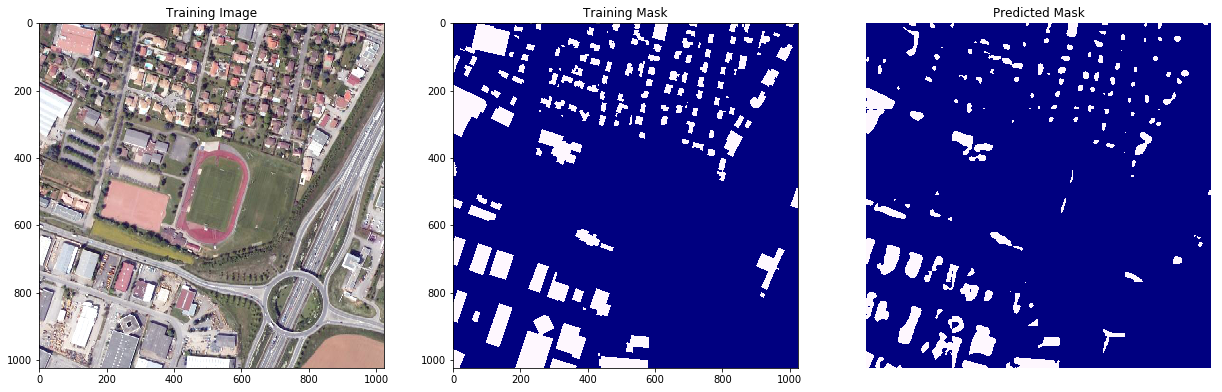

Lyon_1_0


In [41]:
model = get_unet_5()
model.load_weights('1_unet5_c1_rotate.hdf5')
img_id = Image_ID[7]
check_predict(model, 0.8, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


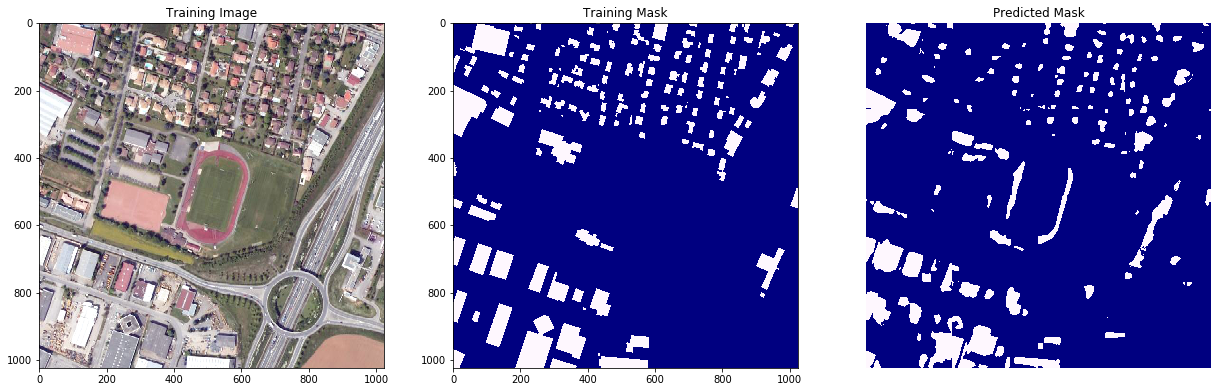

Lyon_1_0


In [24]:
model = get_unet_5()
model.load_weights('1_unet5_c1_.hdf5')
img_id = Image_ID[7]
check_predict(model, 0.8, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


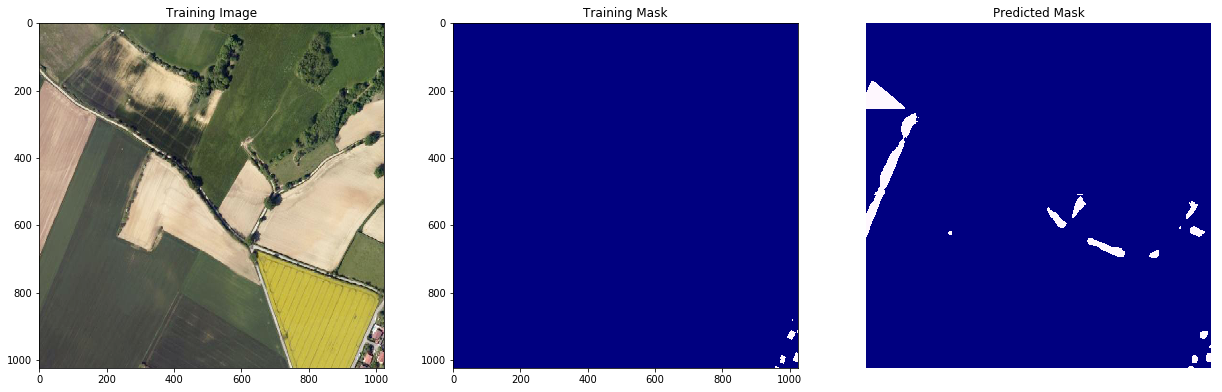

Lyon_0_2


In [44]:
model = get_unet_5()
model.load_weights('1_unet5_c1_rotate.hdf5')
img_id = Image_ID[2]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


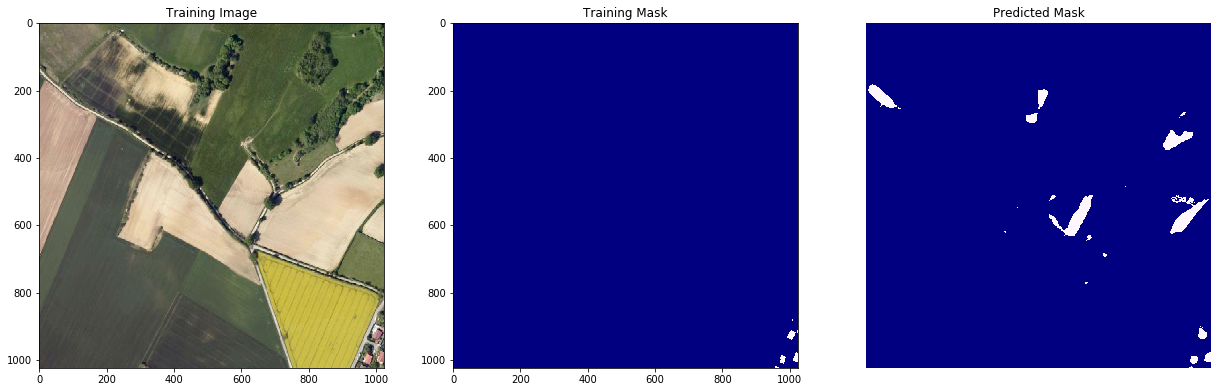

Lyon_0_2


In [16]:
model = get_unet_5()
model.load_weights('1_unet5_c1.hdf5')
img_id = Image_ID[2]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


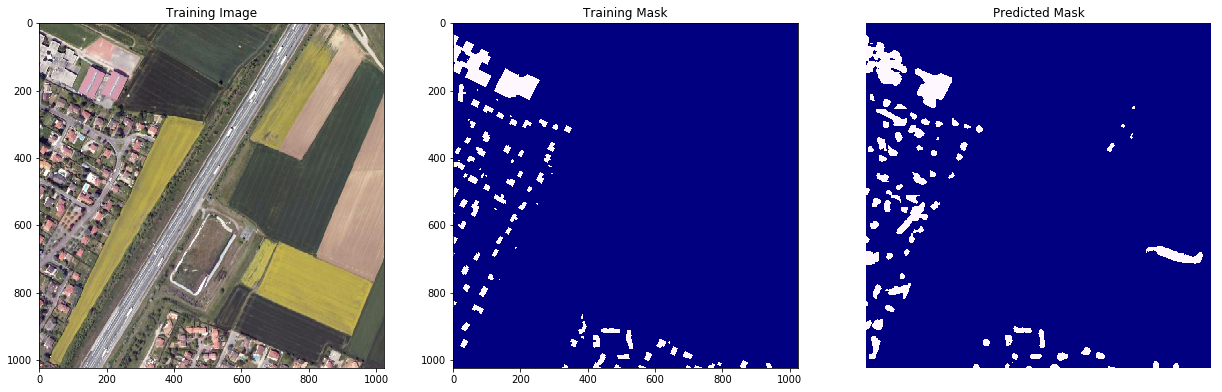

Lyon_0_1


In [45]:
model = get_unet_5()
model.load_weights('1_unet5_c1_rotate.hdf5')
img_id = Image_ID[1]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


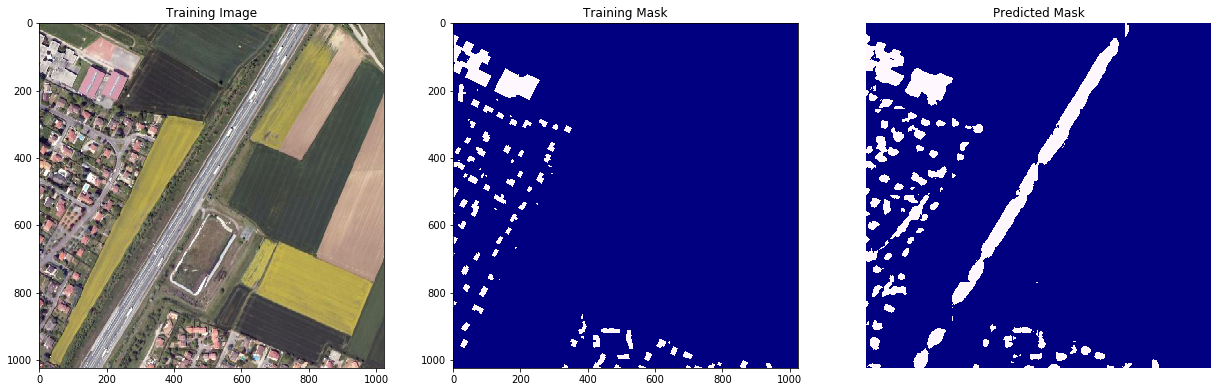

Lyon_0_1


In [17]:
model = get_unet_5()
model.load_weights('1_unet5_c1.hdf5')
img_id = Image_ID[1]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)
